## Notes
* This notebook has implementations of `Backprop` with binary spike feature vectors obtained from the `SPIKEFLOW`. Here, we will use tf.data API. Here the shape of the inputs is `[None, n_input]` instead of `[n_input, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). We also use `z_3 = tf.floor(z_3)`. Surrogate gradients with one step is used. (one sided)

* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
* $\sigma^{'}(z^{(2)})$ is approximated with a surrogate. (See section 6)
* It also takes care of catastrophic forgetting by using synaptic intelligence.
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* [TF memory leaks when  assigning in loop](https://github.com/tensorflow/tensorflow/issues/4151)

In [1]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import pandas as pd
import DATA_Loader
import seaborn as sb
import theano, random, sys, time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Hide code

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Plot chars

### Large

In [3]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

### Small

In [4]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 3.75,3
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

## Load the data 

In [5]:
train_data, validation_data, test_data = DATA_Loader.load_data_wrapper('mnist')
#### LOAD TRAIN AND VALIDATION DATA AND LABELS
train_images = np.concatenate([train_data[0], validation_data[0]], axis=0)
train_labels = train_data[1] + validation_data[1]
train_labels = np.array(train_labels)
test_images = test_data[0]
test_labels = np.array(test_data[1])
num_classes = test_labels.max() + 1

In [6]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [7]:
BATCH_SIZE = 10
#### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TRAIN DATA
def extract_class_data(start=0, stop=1):
    set1_locs = np.where((train_labels>=start) & (train_labels<=stop))[0]
    train_labels_set1 = to_categorical(train_labels[set1_locs], num_classes=num_classes)
    train_images_set1 = train_images[set1_locs,:]
    n_images = len(train_images_set1)

    #### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TEST DATA
    set1_locs = np.where((test_labels>=start) & (test_labels<=stop))[0]
    test_labels_set1 = to_categorical(test_labels[set1_locs], num_classes=num_classes)
    test_images_set1 = test_images[set1_locs,:]
    print('Test features:{}'.format(test_images_set1.shape))
    print('Length of test labels:{}'.format(test_labels_set1.shape[0]))
    test_data_set1 = (test_images_set1, test_labels_set1)
    


    train_images_set1 = train_images_set1[int(0.09*n_images):]
    train_labels_set1 = train_labels_set1[int(0.09*n_images):]
    print('Train features:{}'.format(train_images_set1.shape))
    print('Length of train labels:{}'.format(train_labels_set1.shape[0]))
    train_data_set1 = (train_images_set1, train_labels_set1)

    valid_labels_set1 = train_labels_set1[0:int(0.09*n_images)]
    valid_images_set1 = train_images_set1[0:int(0.09*n_images)]
    print('Valid features:{}'.format(valid_images_set1.shape))
    print('Length of valid labels:{}'.format(valid_labels_set1.shape[0]))
    valid_data_set1 = (valid_images_set1, valid_labels_set1)
    
    n_train_set1 = train_labels_set1.shape[0]
    n_test_set1 = test_labels_set1.shape[0]
    n_valid_set1 = valid_labels_set1.shape[0]

    return train_data_set1, valid_data_set1, test_data_set1

## Start a session

In [8]:
#tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

## Setup the graph

In [9]:
n_input = 784
n_middle = 1024
n_out = 10
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
set1_mask = tf.placeholder(tf.float32, [10], name='mask')
eta = tf.placeholder(tf.float32)
n_tot = tf.placeholder(tf.float32)
lmbda = tf.placeholder(tf.float32, name='lambda')
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    w_2_update_placeholder = tf.placeholder(w_2.dtype, shape=w_2.get_shape(),name='update_w2')
    w_2_update_op = w_2.assign(w_2_update_placeholder)
    tf.summary.histogram('w_2', w_2)
    
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    b_2_update_placeholder = tf.placeholder(b_2.dtype, shape=b_2.get_shape(),name='update_b2')
    b_2_update_op = b_2.assign(b_2_update_placeholder)
    tf.summary.histogram('b_2', b_2)
    
    
    w2_grad_accum = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32),name='w2_grad_accum')
    w2_grad_accum_update_placeholder=tf.placeholder(w2_grad_accum.dtype, shape=w2_grad_accum.get_shape(),
                                            name='update_w2_grad_accum')
    w2_grad_accum_update_op = w2_grad_accum.assign(w2_grad_accum_update_placeholder)
    
    
    b2_grad_accum = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='b2_grad_accum')
    b2_grad_accum_update_placeholder=tf.placeholder(b2_grad_accum.dtype,shape=b2_grad_accum.get_shape(),
                                            name='update_b2_grad_accum')
    b2_grad_accum_update_op = b2_grad_accum.assign(b2_grad_accum_update_placeholder)
    
    
    big_omeg_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='omeg_w2')
    tf.summary.histogram('big_omeg_w2', big_omeg_w2)
    big_omeg_w2_update_placeholder = tf.placeholder(big_omeg_w2.dtype, shape=big_omeg_w2.get_shape(),
                                                    name='update_big_omeg_w2')
    big_omeg_w2_update_op = big_omeg_w2.assign(big_omeg_w2_update_placeholder)
    
    
    big_omeg_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='omeg_b2')
    tf.summary.histogram('big_omeg_b2', big_omeg_b2)
    big_omeg_b2_update_placeholder = tf.placeholder(big_omeg_b2.dtype, shape=big_omeg_b2.get_shape(),
                                                    name='update_big_omeg_b2')
    big_omeg_b2_update_op = big_omeg_b2.assign(big_omeg_b2_update_placeholder)
    
    
    star_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='star_w2')
    star_w2_update_placeholder = tf.placeholder(star_w2.dtype, shape=star_w2.get_shape(),
                                                name='update_star_w2')
    star_w2_update_op = star_w2.assign(star_w2_update_placeholder)
    
    
    star_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='star_b2')
    star_b2_update_placeholder = tf.placeholder(star_b2.dtype, shape=star_b2.get_shape(),
                                                name='update_star_b2')
    star_b2_update_op = star_b2.assign(star_b2_update_placeholder)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    #w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    w_3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    w_3_update_placeholder = tf.placeholder(w_3.dtype, shape=w_3.get_shape(),name='update_w3')
    w_3_update_op = w_3.assign(w_3_update_placeholder)
    
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)
    b_3_update_placeholder = tf.placeholder(b_3.dtype, shape=b_3.get_shape(),name='update_b3')
    b_3_update_op = b_3.assign(b_3_update_placeholder)
    
    w3_grad_accum = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='w3_grad_accum')
    b3_grad_accum = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='b3_grad_accum')
    
    big_omeg_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='omeg_w3')
    tf.summary.histogram('big_omeg_w3', big_omeg_w3)
    big_omeg_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='omeg_b3')
    tf.summary.histogram('big_omeg_b3', big_omeg_b3)
    
    star_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='star_w3')
    star_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='star_b3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def spkPrime1(x):
    l1_bound_higher = tf.greater_equal(x,-0/4)
    r1_bound_lesser = tf.less_equal(x,tau/4) 
    grad_one = tf.where(tf.logical_and(l1_bound_higher,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    return grad_one

def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

    
with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    #@@a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    #@@z_3 = tf.floor(z_3)
    #z_3 = tf.subtract(tf.reduce_max(z_3),z_3, name = 'inhibition')
    tf.summary.histogram('z_3', z_3)
    #@a_3  = sigma(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    a_3 = tf.cast(tf.nn.softmax(z_3,axis=1), tf.float32)
    a_3 = tf.multiply(a_3, set1_mask, name='masking')
    tf.summary.histogram('a_3', a_3)
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),
                          name = 'cost_calc')#WORKS
        ##COMMENT BELOW LINES IF YOU WANT quadratic
    #@dc_da = tf.multiply(-tf.subtract(labels,a_3, name = 'y_minus_a_3'), mask)
    #@cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    #@d_z_3 = tf.multiply(-tf.subtract(labels,a_3, name = 'delta3'), mask, name='masking')
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = tf.expand_dims(tf.reduce_mean(d_z_3, axis=[0]), axis=0)
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(a_2),d_z_3), 
                        name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), ReLUprime(z_2),
                        name = 'delta2')
    #@@d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), spkPrime1(z_2),
    #@@                    name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = tf.expand_dims(tf.reduce_mean(d_z_2, axis=[0]), axis=0)
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(features),d_z_2), 
                        name='delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
omega_step=[tf.assign(w2_grad_accum,
                      tf.add(w2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot, tf.square(d_w_2))),
                     name='update_omeg_w2'),
            tf.assign(b2_grad_accum,
                      tf.add(b2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_b_2))),
                     name='update_omeg_b2')
]

step = [tf.assign(w_2,
                  tf.subtract(w_2, (eta*d_w_2+big_omeg_w2*(w_2-star_w2))),name='update_w_2'),
        tf.assign(b_2,
                  tf.subtract(b_2,(eta*d_b_2+big_omeg_b2*(b_2-star_b2))),name='update_b_2'),
        
        tf.assign(w_3,
                  tf.subtract(w_3, (eta*d_w_3+big_omeg_w3*(w_3-star_w3))),name='update_w_3'),
        tf.assign(b_3,
                  tf.subtract(b_3,(eta*d_b_3+big_omeg_b3*(b_3-star_b3))),name='update_b_3')    
]
with tf.name_scope('acc_calc'):
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

init_op = tf.global_variables_initializer()

## Init the writer with 16 $\lambda$s (0.0, 3.5)

In [15]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/sh_16lmbdas_ar1_3lyrs_he1', sess.graph)

### Generate $\lambda$s

In [16]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=1.0, high=3.5, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[2.35851235 1.69592346 2.06129398 3.11194033 1.01179714 1.3039228
 2.67687271 3.06463189 1.34176647 2.43773332 3.22830489 1.52300531
 1.46332055 1.27094223 1.54924373]
()
[10117.97140477 12709.42226161 13039.22801958 13417.66474212
 14633.20548875 15230.05305293 15492.43731562 16959.23462734
 20612.93976873 23585.12354477 24377.33323568 26768.72711817
 30646.31887763 31119.403308   32283.04885781]
()
([0, 10117.971404774315, 12709.422261606378, 13039.228019577855, 13417.664742123825, 14633.205488751877, 15230.05305292974, 15492.437315624806, 16959.234627344904, 20612.939768728324, 23585.12354477414, 24377.33323568125, 26768.727118169467, 30646.318877626192, 31119.403307997592, 32283.0488578066, 0, 10117.971404774315, 12709.422261606378, 13039.228019577855, 13417.664742123825, 14633.205488751877, 15230.05305292974, 15492.437315624806, 16959.234627344904, 20612.939768728324, 23585.12354477414, 24377.33323568125, 26768.727118169467, 30646.318877626192, 31119.403307997592, 32283.0488578066

### Generate random weights from input to hidden layer
* For 10 consecutive runs with 10 different $\lambda$s, weights will be initialized same. For the next 10 consecutive runs with 10 different $\lambda$s, weights will be initialized same but these weights will be different from previous consecutive weights...

In [17]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(80, 80)


In [18]:
np.array_equal(np_weights[0], np_weights[15])

True

In [19]:
np.array_equal(np_weights[0], np_weights[16])

False

### Commence training

In [ ]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.110008373857 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0464498177171 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0302495043725 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0230062417686 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0189097225666 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0162695497274 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0144200399518 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0130483405665 and training accuracy:0.9977442026

training cost:0.0302495043725 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0230062417686 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0189097225666 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0162695497274 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0144200399518 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0130483405665 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0119868498296 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0111383758485 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0104427644983 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.00986076705158 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0093653537333 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0089377630502 and training 

training cost:0.0119868498296 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0111383758485 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0104427644983 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.00986076705158 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0093653537333 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0089377630502 and training accuracy:0.998004496098
Training on :(0, 1)
Time taken:64.3538808823
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.253814220428 and training accuracy:0.945004999638
Training on :(2, 3)
training cost:0.167405307293 and training accuracy:0.954095065594
Trainin

Time taken:64.0611619949
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.253822445869 and training accuracy:0.945004999638
Training on :(2, 3)
training cost:0.167417883873 and training accuracy:0.954095065594
Training on :(2, 3)
training cost:0.137399867177 and training accuracy:0.960458159447
Training on :(2, 3)
training cost:0.121911883354 and training accuracy:0.963730573654
Training on :(2, 3)
training cost:0.112341083586 and training accuracy:0.964912295341
Training on :(2, 3)
training cost:0.105762787163 and training accuracy:0.966457605362
Training on :(2, 3)
training cost:0.100914098322 and training accuracy:0.968093812466
Training on :(2, 3)
training cost:0.0971590280533 and training accuracy:0.968820989132
Training on :

training cost:0.137416556478 and training accuracy:0.960458159447
Training on :(2, 3)
training cost:0.121929578483 and training accuracy:0.963730573654
Training on :(2, 3)
training cost:0.112359344959 and training accuracy:0.964912295341
Training on :(2, 3)
training cost:0.105781309307 and training accuracy:0.966548502445
Training on :(2, 3)
training cost:0.100932553411 and training accuracy:0.968093812466
Training on :(2, 3)
training cost:0.097177490592 and training accuracy:0.968820989132
Training on :(2, 3)
training cost:0.0941577032208 and training accuracy:0.969820916653
Training on :(2, 3)
training cost:0.0916558429599 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0895339101553 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.08769723773 and training accuracy:0.970548152924
Training on :(2, 3)
training cost:0.0860806703568 and training accuracy:0.970911741257
Training on :(2, 3)
training cost:0.0846364796162 and training accuracy

training cost:0.0942150205374 and training accuracy:0.969820916653
Training on :(2, 3)
training cost:0.0917120873928 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0895889252424 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.0877513661981 and training accuracy:0.970548152924
Training on :(2, 3)
training cost:0.0861335769296 and training accuracy:0.970911741257
Training on :(2, 3)
training cost:0.0846879556775 and training accuracy:0.971638917923
Training on :(2, 3)
Time taken:61.355866909
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.256036549807 and training accuracy:0.954829275608
Training on :(4, 5)
training cost:0.1520691365 and training accuracy:0.970829248428
Training on

Time taken:61.1411781311
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.256161510944 and training accuracy:0.95502436161
Training on :(4, 5)
training cost:0.152218773961 and training accuracy:0.970829248428
Training on :(4, 5)
training cost:0.112537659705 and training accuracy:0.978048801422
Training on :(4, 5)
training cost:0.0919930785894 and training accuracy:0.981268286705
Training on :(4, 5)
training cost:0.0794966220856 and training accuracy:0.984097540379
Training on :(4, 5)
training cost:0.0710854902864 and training accuracy:0.985756099224
Training on :(4, 5)
training cost:0.0650141388178 and training accuracy:0.986536562443
Training on :(4, 5)
training cost:0.060404855758 and training accuracy:0.987024366856
Training on

training cost:0.112604208291 and training accuracy:0.978048801422
Training on :(4, 5)
training cost:0.0920565575361 and training accuracy:0.981268286705
Training on :(4, 5)
training cost:0.0795562118292 and training accuracy:0.984097540379
Training on :(4, 5)
training cost:0.0711409077048 and training accuracy:0.985756099224
Training on :(4, 5)
training cost:0.065065972507 and training accuracy:0.986536562443
Training on :(4, 5)
training cost:0.0604533739388 and training accuracy:0.987024366856
Training on :(4, 5)
training cost:0.0568125136197 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0538503490388 and training accuracy:0.987804889679
Training on :(4, 5)
training cost:0.0513818711042 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0492852441967 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0474737621844 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0458879470825 and training ac

training cost:0.0570585504174 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0540825091302 and training accuracy:0.987804889679
Training on :(4, 5)
training cost:0.0516013130546 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0494927577674 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0476720184088 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0460771657526 and training accuracy:0.988780498505
Training on :(4, 5)
Time taken:57.0447969437
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.108943909407 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0593114383519 and training accuracy:0.996392190456
Trainin

Time taken:57.8800477982
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.110003463924 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0602069571614 and training accuracy:0.996392190456
Training on :(6, 7)
training cost:0.0439197234809 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0357563570142 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.030779318884 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0273852013052 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.02489714697 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0229783207178 and training accuracy:0.997113764286
Training o

training cost:0.0445292517543 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0363138727844 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0312947556376 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0278653427958 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0253467019647 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0234010778368 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0218422766775 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0205570720136 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.019474171102 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0185453929007 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0177369955927 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0170249305665 and training a

### Final accuracy

 	Method3 	lambdas
0 	0.5613 	0.000000
1 	0.5742 	10070.782843
2 	0.5850 	11823.536812
3 	0.5873 	12050.598845
4 	0.5953 	14175.540776
5 	0.6007 	16367.763861
6 	0.6025 	18151.074127
7 	0.6069 	18626.399941
8 	0.6020 	20061.236271
9 	0.6058 	22387.791327
10 	0.5989 	22671.641985
11 	0.5364 	0.000000
12 	0.5450 	10070.782843
13 	0.5482 	11823.536812
14 	0.5561 	12050.598845
15 	0.5504 	14175.540776
16 	0.5572 	16367.763861
17 	0.5613 	18151.074127
18 	0.5610 	18626.399941
19 	0.5708 	20061.236271
20 	0.5744 	22387.791327
21 	0.5752 	22671.641985
22 	0.5546 	0.000000
23 	0.5704 	10070.782843
24 	0.5808 	11823.536812
25 	0.5810 	12050.598845
26 	0.5850 	14175.540776
27 	0.5621 	16367.763861
28 	0.5756 	18151.074127
29 	0.5677 	18626.399941
30 	0.5629 	20061.236271
31 	0.5406 	22387.791327
32 	0.5725 	22671.641985
33 	0.5184 	0.000000
34 	0.5670 	10070.782843
35 	0.5791 	11823.536812
36 	0.5819 	12050.598845
37 	0.6074 	14175.540776
38 	0.6103 	16367.763861
39 	0.6242 	18151.074127
40 	0.6305 	18626.399941
41 	0.6322 	20061.236271
42 	0.6344 	22387.791327
43 	0.6366 	22671.641985

In [21]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('sh_16lmbdas_ar1_3lyrs_he1.csv')
final_test_acc

,Method3,lambdas
0,0.5613,0.000000
1,0.5741,10117.971405
2,0.5809,12709.422262
3,0.5810,13039.228020
4,0.5816,13417.664742
5,0.5830,14633.205489
6,0.5836,15230.053053
7,0.5837,15492.437316
8,0.5829,16959.234627
9,0.5899,20612.939769


#### Group by $\lambda$

In [23]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.53104
10117.971405,0.55964
12709.422262,0.56368
13039.228020,0.56440
13417.664742,0.56502
14633.205489,0.56554
15230.053053,0.56692
15492.437316,0.56724
16959.234627,0.57698


In [24]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.018226
10117.971405,0.010873
12709.422262,0.013270
13039.228020,0.012999
13417.664742,0.012982
14633.205489,0.015024
15230.053053,0.014572
15492.437316,0.014540
16959.234627,0.013171


In [25]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

,Method3
lambdas,
0.000000,0.5613
10117.971405,0.5741
12709.422262,0.5809
13039.228020,0.5810
13417.664742,0.5816
14633.205489,0.5830
15230.053053,0.5836
15492.437316,0.5837
16959.234627,0.5908


#### Plot

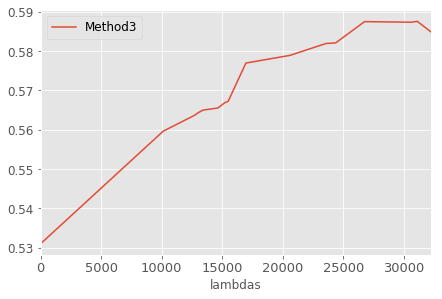

In [26]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')

### Some histograms

#### W_2

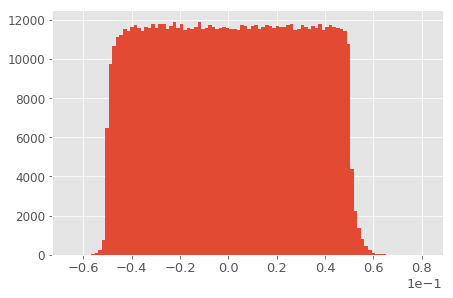

In [27]:
plt.hist(w_2.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### Omega_W_2

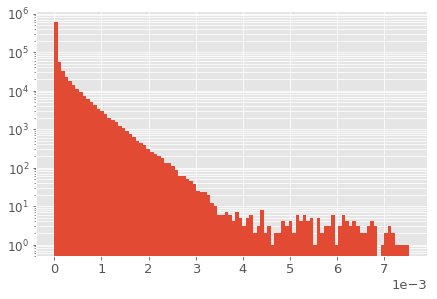

In [28]:
plt.hist(new_big_omeg_w2.flatten(),bins=100,log=True)
#plt.yscale('log')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### b_2

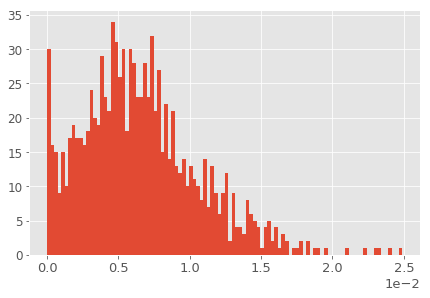

In [29]:
plt.hist(b_2.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### Omega_b_2

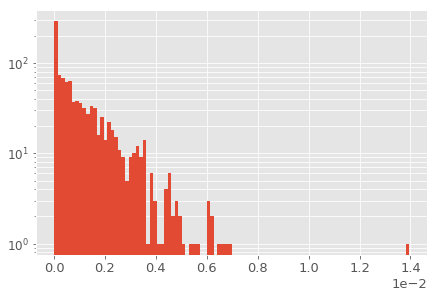

In [30]:
plt.hist(new_big_omeg_b2.flatten(),100,log=True)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### W_3

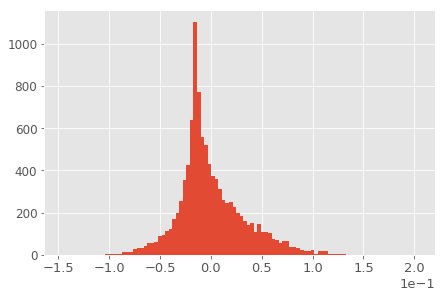

In [31]:
plt.hist(w_3.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### b_3

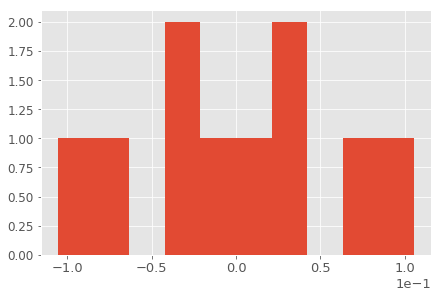

In [32]:
plt.hist(b_3.eval().flatten(), 10)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

## Init the writer with 15 more $\lambda$s from (2.0, 2.75)

In [10]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/sh_15_more_lmbdas_ar1_3lyrs_he1', sess.graph)

### Generate $\lambda$s

In [11]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=2.0, high=2.75, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = a.tolist()*n_reps
print(a, len(a))

[2.40755371 2.20877704 2.31838819 2.6335821  2.00353914 2.09117684
 2.50306181 2.61938957 2.10252994 2.43132    2.66849147 2.15690159
 2.13899616 2.08128267 2.16477312]
()
[20035.39142143 20812.82667848 20911.76840587 21025.29942264
 21389.96164663 21569.01591588 21647.73119469 22087.7703882
 23183.88193062 24075.53706343 24313.1999707  25030.61813545
 26193.89566329 26335.8209924  26684.91465734]
()
([20035.391421432298, 20812.826678481913, 20911.768405873358, 21025.29942263715, 21389.96164662556, 21569.01591587892, 21647.73119468744, 22087.77038820347, 23183.881930618496, 24075.53706343224, 24313.199970704376, 25030.61813545084, 26193.895663287854, 26335.82099239928, 26684.914657341982, 20035.391421432298, 20812.826678481913, 20911.768405873358, 21025.29942263715, 21389.96164662556, 21569.01591587892, 21647.73119468744, 22087.77038820347, 23183.881930618496, 24075.53706343224, 24313.199970704376, 25030.61813545084, 26193.895663287854, 26335.82099239928, 26684.914657341982, 20035.3914

### Generate random weights from input to hidden layer
* For 10 consecutive runs with 15 different $\lambda$s, weights will be initialized same. For the next 15 consecutive runs with 15 different $\lambda$s, weights will be initialized same but these weights will be different from previous consecutive weights...

In [12]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(75, 75)


In [13]:
np.array_equal(np_weights[0], np_weights[14])

True

In [14]:
np.array_equal(np_weights[0], np_weights[15])

False

### Commence training

In [16]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:20035.3914214, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.110008373857 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0464498177171 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0302495043725 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0230062417686 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0189097225666 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0162695497274 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0144200399518 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0130483405665 and training accuracy:

training cost:0.0302495043725 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0230062417686 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0189097225666 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0162695497274 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0144200399518 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0130483405665 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0119868498296 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0111383758485 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0104427644983 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.00986076705158 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0093653537333 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0089377630502 and training 

training cost:0.0119868498296 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0111383758485 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0104427644983 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.00986076705158 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0093653537333 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0089377630502 and training accuracy:0.998004496098
Training on :(0, 1)
Time taken:63.9642539024
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.254017114639 and training accuracy:0.945004999638
Training on :(2, 3)
training cost:0.167713284492 and training accuracy:0.953731477261
Trainin

Time taken:63.8654258251
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.254019886255 and training accuracy:0.945004999638
Training on :(2, 3)
training cost:0.167717531323 and training accuracy:0.953731477261
Training on :(2, 3)
training cost:0.13774292171 and training accuracy:0.96054905653
Training on :(2, 3)
training cost:0.122275091708 and training accuracy:0.963639676571
Training on :(2, 3)
training cost:0.112712584436 and training accuracy:0.964912295341
Training on :(2, 3)
training cost:0.106137312949 and training accuracy:0.966457605362
Training on :(2, 3)
training cost:0.101286999881 and training accuracy:0.968093812466
Training on :(2, 3)
training cost:0.0975262895226 and training accuracy:0.968820989132
Training on :(2

training cost:0.137758105993 and training accuracy:0.96054905653
Training on :(2, 3)
training cost:0.122291043401 and training accuracy:0.963548779488
Training on :(2, 3)
training cost:0.112728923559 and training accuracy:0.964912295341
Training on :(2, 3)
training cost:0.10615362227 and training accuracy:0.966457605362
Training on :(2, 3)
training cost:0.101303204894 and training accuracy:0.968093812466
Training on :(2, 3)
training cost:0.0975420996547 and training accuracy:0.968820989132
Training on :(2, 3)
training cost:0.0945146456361 and training accuracy:0.969820916653
Training on :(2, 3)
training cost:0.0920055583119 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0898751541972 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.0880312845111 and training accuracy:0.97045725584
Training on :(2, 3)
training cost:0.0864059999585 and training accuracy:0.97100263834
Training on :(2, 3)
training cost:0.0849542766809 and training accuracy:

training cost:0.094522356987 and training accuracy:0.969820916653
Training on :(2, 3)
training cost:0.0920131504536 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0898824632168 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.0880382582545 and training accuracy:0.97045725584
Training on :(2, 3)
training cost:0.0864127352834 and training accuracy:0.97100263834
Training on :(2, 3)
training cost:0.0849608555436 and training accuracy:0.971638917923
Training on :(2, 3)
Time taken:61.1183519363
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.257427364588 and training accuracy:0.955317080021
Training on :(4, 5)
training cost:0.153681531549 and training accuracy:0.971024394035
Training on

Time taken:61.2778270245
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.257442802191 and training accuracy:0.955317080021
Training on :(4, 5)
training cost:0.153698474169 and training accuracy:0.971024394035
Training on :(4, 5)
training cost:0.114024318755 and training accuracy:0.977756083012
Training on :(4, 5)
training cost:0.0934019684792 and training accuracy:0.981170713902
Training on :(4, 5)
training cost:0.0808084607124 and training accuracy:0.98400002718
Training on :(4, 5)
training cost:0.072302415967 and training accuracy:0.985658526421
Training on :(4, 5)
training cost:0.066146068275 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0614608004689 and training accuracy:0.986926853657
Training on 

training cost:0.114116951823 and training accuracy:0.977756083012
Training on :(4, 5)
training cost:0.0934890657663 and training accuracy:0.981170713902
Training on :(4, 5)
training cost:0.0808889940381 and training accuracy:0.98400002718
Training on :(4, 5)
training cost:0.0723770707846 and training accuracy:0.985658526421
Training on :(4, 5)
training cost:0.0662151873112 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0615249909461 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0578164421022 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0547944568098 and training accuracy:0.987804889679
Training on :(4, 5)
training cost:0.0522740371525 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0501317158341 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.04828017205 and training accuracy:0.988390266895
Training on :(4, 5)
training cost:0.0466582514346 and training accu

training cost:0.0579614490271 and training accuracy:0.987317085266
Training on :(4, 5)
training cost:0.0549308918417 and training accuracy:0.987804889679
Training on :(4, 5)
training cost:0.0524028912187 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0502537861466 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0483960546553 and training accuracy:0.988390266895
Training on :(4, 5)
training cost:0.0467692539096 and training accuracy:0.988878071308
Training on :(4, 5)
Time taken:56.4441969395
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.11070625484 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0607958585024 and training accuracy:0.996392190456
Training

Time taken:56.7262721062
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.110942877829 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.060993373394 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0446259491146 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0364020355046 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0313759632409 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0279406644404 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0254169888794 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.023467136547 and training accuracy:0.997203946114
Training 

training cost:0.0446723885834 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0364442430437 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0314148887992 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0279766954482 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0254505425692 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0234986506402 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.021934164688 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0206441320479 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0195568688214 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0186240375042 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0178120043129 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0170967169106 and training a

training cost:0.022023005411 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.020728090778 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0196364987642 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.018699798733 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0178843811154 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0171658173203 and training accuracy:0.997654914856
Training on :(6, 7)
Time taken:61.763586998
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.204387292266 and training accuracy:0.957906484604
Training on :(8, 9)
training cost:0.143018573523 and training accuracy:0.963494122028
Training on 

Time taken:62.1244621277
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.204879850149 and training accuracy:0.957813382149
Training on :(8, 9)
training cost:0.143354564905 and training accuracy:0.963494122028
Training on :(8, 9)
training cost:0.120598651469 and training accuracy:0.966008543968
Training on :(8, 9)
training cost:0.108049914241 and training accuracy:0.968802392483
Training on :(8, 9)
training cost:0.0997537374496 and training accuracy:0.970571815968
Training on :(8, 9)
training cost:0.0937049016356 and training accuracy:0.972154974937
Training on :(8, 9)
training cost:0.0890223011374 and training accuracy:0.973365604877
Training on :(8, 9)
training cost:0.085246026516 and training accuracy:0.974203765392
Training on

training cost:0.120633505285 and training accuracy:0.965915441513
Training on :(8, 9)
training cost:0.108082272112 and training accuracy:0.968802392483
Training on :(8, 9)
training cost:0.0997840091586 and training accuracy:0.970571815968
Training on :(8, 9)
training cost:0.0937335267663 and training accuracy:0.972154974937
Training on :(8, 9)
training cost:0.0890494287014 and training accuracy:0.973365604877
Training on :(8, 9)
training cost:0.0852718427777 and training accuracy:0.974203765392
Training on :(8, 9)
training cost:0.0821347087622 and training accuracy:0.975041925907
Training on :(8, 9)
training cost:0.0794697552919 and training accuracy:0.975600659847
Training on :(8, 9)
training cost:0.0771642252803 and training accuracy:0.976159453392
Training on :(8, 9)
training cost:0.0751407369971 and training accuracy:0.976531922817
Training on :(8, 9)
training cost:0.0733409896493 and training accuracy:0.976718187332
Training on :(8, 9)
training cost:0.0717261061072 and training ac

training cost:0.0821977183223 and training accuracy:0.975041925907
Training on :(8, 9)
training cost:0.0795304998755 and training accuracy:0.975600659847
Training on :(8, 9)
training cost:0.0772227868438 and training accuracy:0.976252555847
Training on :(8, 9)
training cost:0.0751977190375 and training accuracy:0.976531922817
Training on :(8, 9)
training cost:0.0733965709805 and training accuracy:0.976718187332
Training on :(8, 9)
training cost:0.0717802271247 and training accuracy:0.977370083332
Training on :(8, 9)
Time taken:60.2122600079
Method 3 test accuracy:0.595899999142
Training with lmbda:20035.3914214, 15
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109210990369 and training accuracy:0.995748758316
Trainin

Time taken:60.0838010311
Method 3 test accuracy:0.554799973965
Training with lmbda:20812.8266785, 16
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109210990369 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467881597579 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0307176131755 and training accuracy:0.996963381767
Training on :(0, 1)
training cost:0.0234973598272 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193961337209 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0167423952371 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0148768387735 and training accuracy:0.997657477856
Trainin

training cost:0.0467881597579 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0307176131755 and training accuracy:0.996963381767
Training on :(0, 1)
training cost:0.0234973598272 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193961337209 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0167423952371 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0148768387735 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0134880719706 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124092334881 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0115437982604 and training accuracy:0.997917771339
Training on :(0, 1)
training cost:0.0108319735155 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.0102344285697 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00972424540669 and training

training cost:0.0134880719706 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124092334881 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0115437982604 and training accuracy:0.997917771339
Training on :(0, 1)
training cost:0.0108319735155 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.0102344285697 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00972424540669 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00928265508264 and training accuracy:0.99809128046
Training on :(0, 1)
Time taken:64.5271799564
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260489434004 and training accuracy:0.944732308388
Traini

training cost:0.00928265508264 and training accuracy:0.99809128046
Training on :(0, 1)
Time taken:64.4382829666
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260499089956 and training accuracy:0.944732308388
Training on :(2, 3)
training cost:0.17050743103 and training accuracy:0.954185962677
Training on :(2, 3)
training cost:0.13949623704 and training accuracy:0.959912717342
Training on :(2, 3)
training cost:0.123634420335 and training accuracy:0.9629124403
Training on :(2, 3)
training cost:0.113862976432 and training accuracy:0.965275883675
Training on :(2, 3)
training cost:0.107156164944 and training accuracy:0.967093884945
Training on :(2, 3)
training cost:0.102209858596 and training accuracy:0.968184709549
Training on :(2, 

training cost:0.170514672995 and training accuracy:0.954185962677
Training on :(2, 3)
training cost:0.139504462481 and training accuracy:0.959912717342
Training on :(2, 3)
training cost:0.123643189669 and training accuracy:0.9629124403
Training on :(2, 3)
training cost:0.113871537149 and training accuracy:0.965275883675
Training on :(2, 3)
training cost:0.10716497153 and training accuracy:0.967093884945
Training on :(2, 3)
training cost:0.102218642831 and training accuracy:0.968184709549
Training on :(2, 3)
training cost:0.0983736366034 and training accuracy:0.969730019569
Training on :(2, 3)
training cost:0.0952680259943 and training accuracy:0.970548152924
Training on :(2, 3)
training cost:0.0926821902394 and training accuracy:0.97154802084
Training on :(2, 3)
training cost:0.0904770568013 and training accuracy:0.97154802084
Training on :(2, 3)
training cost:0.088560461998 and training accuracy:0.972093462944
Training on :(2, 3)
training cost:0.0868665501475 and training accuracy:0.9

training cost:0.0983775556087 and training accuracy:0.969730019569
Training on :(2, 3)
training cost:0.0952719002962 and training accuracy:0.970548152924
Training on :(2, 3)
training cost:0.0926859378815 and training accuracy:0.97154802084
Training on :(2, 3)
training cost:0.0904806926847 and training accuracy:0.97154802084
Training on :(2, 3)
training cost:0.0885639861226 and training accuracy:0.972093462944
Training on :(2, 3)
training cost:0.0868699327111 and training accuracy:0.972366154194
Training on :(2, 3)
training cost:0.085353910923 and training accuracy:0.97282063961
Training on :(2, 3)
Time taken:62.0348701477
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.253392010927 and training accuracy:0.957853674889
Training on

training cost:0.0853727161884 and training accuracy:0.972729742527
Training on :(2, 3)
Time taken:61.5081291199
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.253473371267 and training accuracy:0.957853674889
Training on :(4, 5)
training cost:0.150779113173 and training accuracy:0.972000002861
Training on :(4, 5)
training cost:0.111677281559 and training accuracy:0.978926837444
Training on :(4, 5)
training cost:0.0914613753557 and training accuracy:0.982146322727
Training on :(4, 5)
training cost:0.0791801139712 and training accuracy:0.984585344791
Training on :(4, 5)
training cost:0.0709193795919 and training accuracy:0.985463440418
Training on :(4, 5)
training cost:0.0649555549026 and training accuracy:0.986243903637
Training 

training cost:0.151012510061 and training accuracy:0.972000002861
Training on :(4, 5)
training cost:0.11191508919 and training accuracy:0.978926837444
Training on :(4, 5)
training cost:0.0916875824332 and training accuracy:0.982146322727
Training on :(4, 5)
training cost:0.0793900042772 and training accuracy:0.984585344791
Training on :(4, 5)
training cost:0.0711125060916 and training accuracy:0.985463440418
Training on :(4, 5)
training cost:0.0651335939765 and training accuracy:0.986243903637
Training on :(4, 5)
training cost:0.0605858713388 and training accuracy:0.987024366856
Training on :(4, 5)
training cost:0.0569878295064 and training accuracy:0.987609744072
Training on :(4, 5)
training cost:0.0540539734066 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.0516041219234 and training accuracy:0.988195121288
Training on :(4, 5)
training cost:0.0495166778564 and training accuracy:0.988585352898
Training on :(4, 5)
training cost:0.0477097928524 and training acc

training cost:0.0607154518366 and training accuracy:0.987024366856
Training on :(4, 5)
training cost:0.057107783854 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.054166123271 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.0517095662653 and training accuracy:0.988195121288
Training on :(4, 5)
training cost:0.0496159233153 and training accuracy:0.988585352898
Training on :(4, 5)
training cost:0.047803927213 and training accuracy:0.98907315731
Training on :(4, 5)
training cost:0.046214800328 and training accuracy:0.989268302917
Training on :(4, 5)
Time taken:57.3941340446
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.114425346255 and training accuracy:0.995309829712
Training on 

training cost:0.0462386906147 and training accuracy:0.989268302917
Training on :(4, 5)
Time taken:57.7504479885
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.114489555359 and training accuracy:0.995309829712
Training on :(6, 7)
training cost:0.062847957015 and training accuracy:0.995850980282
Training on :(6, 7)
training cost:0.0458721108735 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.0373529531062 and training accuracy:0.996482372284
Training on :(6, 7)
training cost:0.0321518145502 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.028596997261 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0259833652526 and training accuracy:0.997294127941
Training 

training cost:0.0630125999451 and training accuracy:0.995850980282
Training on :(6, 7)
training cost:0.0460211336613 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.037488296628 and training accuracy:0.996482372284
Training on :(6, 7)
training cost:0.0322752222419 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.0287100821733 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0260875225067 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0240593273193 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0224323887378 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.021090388298 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0199594032019 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0189897660166 and training accuracy:0.998015701771
Training on :(6, 7)
training cost:0.0181465037167 and training ac

training cost:0.0241790376604 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0225442070514 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0211955197155 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0200586542487 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0190840084106 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0182361975312 and training accuracy:0.998015701771
Training on :(6, 7)
training cost:0.0174901094288 and training accuracy:0.998196065426
Training on :(6, 7)
Time taken:62.7448458672
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.204763635993 and training accuracy:0.957720220089
Trainin

training cost:0.0175029728562 and training accuracy:0.998196065426
Training on :(6, 7)
Time taken:62.5835950375
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.204826116562 and training accuracy:0.957720220089
Training on :(8, 9)
training cost:0.145341455936 and training accuracy:0.962469756603
Training on :(8, 9)
training cost:0.123075202107 and training accuracy:0.964611649513
Training on :(8, 9)
training cost:0.110624194145 and training accuracy:0.966846704483
Training on :(8, 9)
training cost:0.102297388017 and training accuracy:0.969361126423
Training on :(8, 9)
training cost:0.0961723774672 and training accuracy:0.970758080482
Training on :(8, 9)
training cost:0.0913989245892 and training accuracy:0.972341239452
Training on

training cost:0.145446062088 and training accuracy:0.962562859058
Training on :(8, 9)
training cost:0.12316544354 and training accuracy:0.964611649513
Training on :(8, 9)
training cost:0.110706016421 and training accuracy:0.966846704483
Training on :(8, 9)
training cost:0.102374270558 and training accuracy:0.969454288483
Training on :(8, 9)
training cost:0.0962464138865 and training accuracy:0.970758080482
Training on :(8, 9)
training cost:0.0914696231484 and training accuracy:0.972341239452
Training on :(8, 9)
training cost:0.087597116828 and training accuracy:0.973179340363
Training on :(8, 9)
training cost:0.0843706279993 and training accuracy:0.974017500877
Training on :(8, 9)
training cost:0.0816233232617 and training accuracy:0.974762499332
Training on :(8, 9)
training cost:0.0792443007231 and training accuracy:0.975507557392
Training on :(8, 9)
training cost:0.0771555602551 and training accuracy:0.976159453392
Training on :(8, 9)
training cost:0.0752972513437 and training accura

training cost:0.0844524800777 and training accuracy:0.972993135452
Training on :(8, 9)
training cost:0.0813826993108 and training accuracy:0.973924398422
Training on :(8, 9)
training cost:0.0787631720304 and training accuracy:0.974762499332
Training on :(8, 9)
training cost:0.0764869600534 and training accuracy:0.975228190422
Training on :(8, 9)
training cost:0.0744820460677 and training accuracy:0.975786924362
Training on :(8, 9)
training cost:0.0726950615644 and training accuracy:0.976159453392
Training on :(8, 9)
training cost:0.0710850283504 and training accuracy:0.976625084877
Training on :(8, 9)
Time taken:61.6383168697
Method 3 test accuracy:0.558200001717
Training with lmbda:20812.8266785, 31
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Traini

training cost:0.0712178498507 and training accuracy:0.976718187332
Training on :(8, 9)
Time taken:59.6382749081
Method 3 test accuracy:0.559599995613
Training with lmbda:20911.7684059, 32
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.108751513064 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467011146247 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0306682921946 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.023459430784 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193667355925 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0167201757431 and training accuracy:0.997483968735
Training

Training on :(0, 1)
training cost:0.108751513064 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467011146247 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0306682921946 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.023459430784 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193667355925 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0167201757431 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0148603999987 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0134757561609 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124004138634 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0115378955379 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.010828259401 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0102326646

training cost:0.0167201757431 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0148603999987 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0134757561609 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124004138634 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0115378955379 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.010828259401 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0102326646447 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00972426123917 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00928423460573 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:64.7633202076
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of

training cost:0.0102326646447 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00972426123917 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00928423460573 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:65.130453825
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.271235227585 and training accuracy:0.945277690887
Training on :(2, 3)
training cost:0.173542648554 and training accuracy:0.955004096031
Training on :(2, 3)
training cost:0.140808731318 and training accuracy:0.959276437759
Training on :(2, 3)
training cost:0.124352686107 and training accuracy:0.963366985321
Training on :(2, 3)
training cost:0.11431851238 and training accuracy:0.966094017029
Training on

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.27123734355 and training accuracy:0.945277690887
Training on :(2, 3)
training cost:0.173545718193 and training accuracy:0.955004096031
Training on :(2, 3)
training cost:0.14081209898 and training accuracy:0.959276437759
Training on :(2, 3)
training cost:0.124356217682 and training accuracy:0.963366985321
Training on :(2, 3)
training cost:0.11432223767 and training accuracy:0.966094017029
Training on :(2, 3)
training cost:0.107479617 and training accuracy:0.966275811195
Training on :(2, 3)
training cost:0.102448783815 and training accuracy:0.967093884945
Training on :(2, 3)
training cost:0.098551876843 and training accuracy:0.968275606632
Training on :(2, 3)
training cost:0.0954137146473 and training accuracy:0.96891194582
Training on :(2, 3)
training cost:0.0928063541651 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0905899778008 and training accuracy:0.97027540

training cost:0.107499428093 and training accuracy:0.966275811195
Training on :(2, 3)
training cost:0.102468371391 and training accuracy:0.967093884945
Training on :(2, 3)
training cost:0.0985708758235 and training accuracy:0.968275606632
Training on :(2, 3)
training cost:0.0954323410988 and training accuracy:0.96891194582
Training on :(2, 3)
training cost:0.0928245186806 and training accuracy:0.970002710819
Training on :(2, 3)
training cost:0.0906075313687 and training accuracy:0.970275402069
Training on :(2, 3)
training cost:0.088681191206 and training accuracy:0.971184432507
Training on :(2, 3)
training cost:0.0869801267982 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0854569226503 and training accuracy:0.97154802084
Training on :(2, 3)
Time taken:61.5050258636
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid 

training cost:0.0887247025967 and training accuracy:0.971184432507
Training on :(2, 3)
training cost:0.0870220437646 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0854980200529 and training accuracy:0.97154802084
Training on :(2, 3)
Time taken:62.3029289246
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.264322161674 and training accuracy:0.951804876328
Training on :(4, 5)
training cost:0.158670306206 and training accuracy:0.96936583519
Training on :(4, 5)
training cost:0.118307940662 and training accuracy:0.975707292557
Training on :(4, 5)
training cost:0.0972265005112 and training accuracy:0.980390250683
Training on :(4, 5)
training cost:0.0842911750078 and training accuracy:0.982829272747
Training on 

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.264501959085 and training accuracy:0.951804876328
Training on :(4, 5)
training cost:0.158882603049 and training accuracy:0.969463407993
Training on :(4, 5)
training cost:0.11852260679 and training accuracy:0.975707292557
Training on :(4, 5)
training cost:0.0974302440882 and training accuracy:0.980390250683
Training on :(4, 5)
training cost:0.0844810754061 and training accuracy:0.982731699944
Training on :(4, 5)
training cost:0.0756961554289 and training accuracy:0.984292685986
Training on :(4, 5)
training cost:0.0693125128746 and training accuracy:0.985560953617
Training on :(4, 5)
training cost:0.0644372180104 and training accuracy:0.98634147644
Training on :(4, 5)
training cost:0.0605732314289 and training accuracy:0.98673170805
Training on :(4, 5)
training cost:0.0574182607234 and training accuracy:0.987024366856
Training on :(4, 5)
training cost:0.0547820404172 and training accuracy:0

training cost:0.0757422447205 and training accuracy:0.984292685986
Training on :(4, 5)
training cost:0.0693553388119 and training accuracy:0.985560953617
Training on :(4, 5)
training cost:0.0644769892097 and training accuracy:0.98634147644
Training on :(4, 5)
training cost:0.0606103651226 and training accuracy:0.98673170805
Training on :(4, 5)
training cost:0.0574531555176 and training accuracy:0.987024366856
Training on :(4, 5)
training cost:0.0548151545227 and training accuracy:0.987317085266
Training on :(4, 5)
training cost:0.0525670237839 and training accuracy:0.98741465807
Training on :(4, 5)
training cost:0.0506219640374 and training accuracy:0.987609744072
Training on :(4, 5)
training cost:0.0489171296358 and training accuracy:0.987707316875
Training on :(4, 5)
Time taken:57.7341470718
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of val

training cost:0.0526591427624 and training accuracy:0.98741465807
Training on :(4, 5)
training cost:0.0507094971836 and training accuracy:0.987609744072
Training on :(4, 5)
training cost:0.0490002818406 and training accuracy:0.987707316875
Training on :(4, 5)
Time taken:57.8066780567
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.111856266856 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0609484612942 and training accuracy:0.996392190456
Training on :(6, 7)
training cost:0.0443686433136 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0360563807189 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0309765283018 and training accuracy:0.997474491596
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.112154483795 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0612031817436 and training accuracy:0.996392190456
Training on :(6, 7)
training cost:0.0445953570306 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0362595953047 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0311600789428 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.027668653056 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0250995233655 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0231122970581 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0215190928429 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.020205963403 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0190998557955 and training accurac

training cost:0.0276887007058 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0251180008054 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0231294427067 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0215350612998 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.020220912993 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0191139001399 and training accuracy:0.997925519943
Training on :(6, 7)
training cost:0.0181655175984 and training accuracy:0.998015701771
Training on :(6, 7)
training cost:0.0173413138837 and training accuracy:0.998196065426
Training on :(6, 7)
training cost:0.0166163593531 and training accuracy:0.998196065426
Training on :(6, 7)
Time taken:62.5829548836
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of v

training cost:0.0181979555637 and training accuracy:0.998015701771
Training on :(6, 7)
training cost:0.0173720214516 and training accuracy:0.998196065426
Training on :(6, 7)
training cost:0.0166456084698 and training accuracy:0.998196065426
Training on :(6, 7)
Time taken:62.4560379982
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.199561402202 and training accuracy:0.960979700089
Training on :(8, 9)
training cost:0.141272544861 and training accuracy:0.963401019573
Training on :(8, 9)
training cost:0.119774051011 and training accuracy:0.966008543968
Training on :(8, 9)
training cost:0.107832320035 and training accuracy:0.967777967453
Training on :(8, 9)
training cost:0.099864885211 and training accuracy:0.969174921513
Training on

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.203887209296 and training accuracy:0.957999646664
Training on :(8, 9)
training cost:0.143809333444 and training accuracy:0.962097227573
Training on :(8, 9)
training cost:0.12137363106 and training accuracy:0.965170443058
Training on :(8, 9)
training cost:0.108904205263 and training accuracy:0.967405498028
Training on :(8, 9)
training cost:0.100610800087 and training accuracy:0.969733655453
Training on :(8, 9)
training cost:0.0945386737585 and training accuracy:0.971316814423
Training on :(8, 9)
training cost:0.0898238271475 and training accuracy:0.973179340363
Training on :(8, 9)
training cost:0.0860163122416 and training accuracy:0.974296867847
Training on :(8, 9)
training cost:0.0828507989645 and training accuracy:0.975041925907
Training on :(8, 9)
training cost:0.0801595672965 and training accuracy:0.975786924362
Training on :(8, 9)
training cost:0.0778314098716 and training accuracy:0

training cost:0.0947166755795 and training accuracy:0.971316814423
Training on :(8, 9)
training cost:0.0899965912104 and training accuracy:0.973179340363
Training on :(8, 9)
training cost:0.0861836522818 and training accuracy:0.974110662937
Training on :(8, 9)
training cost:0.0830139368773 and training accuracy:0.975041925907
Training on :(8, 9)
training cost:0.0803187564015 and training accuracy:0.975786924362
Training on :(8, 9)
training cost:0.0779867246747 and training accuracy:0.976252555847
Training on :(8, 9)
training cost:0.0759393125772 and training accuracy:0.976531922817
Training on :(8, 9)
training cost:0.0741208344698 and training accuracy:0.976997554302
Training on :(8, 9)
training cost:0.0724860653281 and training accuracy:0.977183818817
Training on :(8, 9)
Time taken:60.7218768597
Method 3 test accuracy:0.598900020123
Training with lmbda:20911.7684059, 47
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11

training cost:0.075957685709 and training accuracy:0.976531922817
Training on :(8, 9)
training cost:0.0741387158632 and training accuracy:0.976997554302
Training on :(8, 9)
training cost:0.0725034996867 and training accuracy:0.977183818817
Training on :(8, 9)
Time taken:60.5636711121
Method 3 test accuracy:0.599099993706
Training with lmbda:21025.2994226, 48
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.111068069935 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0471392162144 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0308596212417 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.0235807783902 and training accuracy:0.997397184372
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.111068069935 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0471392162144 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0308596212417 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.0235807783902 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0194607246667 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0168019216508 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0149351535365 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0135461715981 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0124680222943 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0116031467915 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0108915325254 and tra

training cost:0.0168019216508 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0149351535365 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0135461715981 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0124680222943 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0116031467915 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0108915325254 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0102940537035 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.00978401023895 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00934234075248 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:65.9933531284
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length o

training cost:0.0102940537035 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.00978401023895 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00934234075248 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:64.9328570366
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.267310887575 and training accuracy:0.946823000908
Training on :(2, 3)
training cost:0.172602668405 and training accuracy:0.954822301865
Training on :(2, 3)
training cost:0.140446901321 and training accuracy:0.959640026093
Training on :(2, 3)
training cost:0.12409504503 and training accuracy:0.963548779488
Training on :(2, 3)
training cost:0.114051923156 and training accuracy:0.965912163258
Training o

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.267323195934 and training accuracy:0.946823000908
Training on :(2, 3)
training cost:0.172621399164 and training accuracy:0.954822301865
Training on :(2, 3)
training cost:0.140468016267 and training accuracy:0.959640026093
Training on :(2, 3)
training cost:0.124116942286 and training accuracy:0.963548779488
Training on :(2, 3)
training cost:0.114073827863 and training accuracy:0.965912163258
Training on :(2, 3)
training cost:0.107194952667 and training accuracy:0.966639399529
Training on :(2, 3)
training cost:0.102130495012 and training accuracy:0.967821121216
Training on :(2, 3)
training cost:0.0982108339667 and training accuracy:0.968457400799
Training on :(2, 3)
training cost:0.0950576514006 and training accuracy:0.969730019569
Training on :(2, 3)
training cost:0.0924419686198 and training accuracy:0.970639050007
Training on :(2, 3)
training cost:0.0902199745178 and training accuracy:0.

training cost:0.107250235975 and training accuracy:0.966639399529
Training on :(2, 3)
training cost:0.102184943855 and training accuracy:0.967821121216
Training on :(2, 3)
training cost:0.0982637926936 and training accuracy:0.968457400799
Training on :(2, 3)
training cost:0.0951094925404 and training accuracy:0.969730019569
Training on :(2, 3)
training cost:0.0924921706319 and training accuracy:0.970639050007
Training on :(2, 3)
training cost:0.0902684181929 and training accuracy:0.970639050007
Training on :(2, 3)
training cost:0.0883407592773 and training accuracy:0.97100263834
Training on :(2, 3)
training cost:0.0866408422589 and training accuracy:0.97154802084
Training on :(2, 3)
training cost:0.0851199701428 and training accuracy:0.971638917923
Training on :(2, 3)
Time taken:61.6054019928
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of vali

training cost:0.0883790552616 and training accuracy:0.97100263834
Training on :(2, 3)
training cost:0.0866778865457 and training accuracy:0.97154802084
Training on :(2, 3)
training cost:0.0851555913687 and training accuracy:0.971729815006
Training on :(2, 3)
Time taken:61.6925148964
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.26831522584 and training accuracy:0.947024405003
Training on :(4, 5)
training cost:0.16146145761 and training accuracy:0.967317044735
Training on :(4, 5)
training cost:0.120146796107 and training accuracy:0.976292669773
Training on :(4, 5)
training cost:0.0984377861023 and training accuracy:0.97990244627
Training on :(4, 5)
training cost:0.0850665345788 and training accuracy:0.981658518314
Training on :(

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.268364518881 and training accuracy:0.947024405003
Training on :(4, 5)
training cost:0.161519050598 and training accuracy:0.967317044735
Training on :(4, 5)
training cost:0.120204016566 and training accuracy:0.97619509697
Training on :(4, 5)
training cost:0.098491333425 and training accuracy:0.97990244627
Training on :(4, 5)
training cost:0.0851148664951 and training accuracy:0.981658518314
Training on :(4, 5)
training cost:0.0760275796056 and training accuracy:0.983707308769
Training on :(4, 5)
training cost:0.0694249272346 and training accuracy:0.985073149204
Training on :(4, 5)
training cost:0.0643875822425 and training accuracy:0.985951244831
Training on :(4, 5)
training cost:0.0604024268687 and training accuracy:0.986829280853
Training on :(4, 5)
training cost:0.0571545772254 and training accuracy:0.987317085266
Training on :(4, 5)
training cost:0.0544462762773 and training accuracy:0

training cost:0.07615929842 and training accuracy:0.983707308769
Training on :(4, 5)
training cost:0.0695456042886 and training accuracy:0.985073149204
Training on :(4, 5)
training cost:0.0644992217422 and training accuracy:0.985951244831
Training on :(4, 5)
training cost:0.0605063475668 and training accuracy:0.986829280853
Training on :(4, 5)
training cost:0.0572517849505 and training accuracy:0.987317085266
Training on :(4, 5)
training cost:0.0545377396047 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.0522318743169 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.0502406284213 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0484972335398 and training accuracy:0.988292694092
Training on :(4, 5)
Time taken:57.7784180641
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of va

training cost:0.0523705743253 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.0503712594509 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0486224591732 and training accuracy:0.988292694092
Training on :(4, 5)
Time taken:57.6711878777
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.120355844498 and training accuracy:0.994768619537
Training on :(6, 7)
training cost:0.0646566897631 and training accuracy:0.995580434799
Training on :(6, 7)
training cost:0.046820409596 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0379925258458 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.0326487533748 and training accuracy:0.996843159199
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.120396584272 and training accuracy:0.994768619537
Training on :(6, 7)
training cost:0.0646906122565 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0468507297337 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0380200967193 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.0326741188765 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0290419608355 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0263836309314 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0243359841406 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0226979069412 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0213491525501 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0202134195715 and training accur

training cost:0.0290988348424 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0264366921037 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0243855454028 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0227444060147 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0213929656893 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0202548410743 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0192788299173 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0184300430119 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0176825039089 and training accuracy:0.997925519943
Training on :(6, 7)
Time taken:62.7123391628
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of 

training cost:0.0181546155363 and training accuracy:0.998196065426
Training on :(6, 7)
training cost:0.017345122993 and training accuracy:0.998286306858
Training on :(6, 7)
training cost:0.016632784158 and training accuracy:0.998286306858
Training on :(6, 7)
Time taken:62.553508997
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.19928508997 and training accuracy:0.959582805634
Training on :(8, 9)
training cost:0.141261786222 and training accuracy:0.963214755058
Training on :(8, 9)
training cost:0.119561299682 and training accuracy:0.965729176998
Training on :(8, 9)
training cost:0.107472874224 and training accuracy:0.967964231968
Training on :(8, 9)
training cost:0.0994159504771 and training accuracy:0.970199286938
Training on :(

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.199643775821 and training accuracy:0.959489643574
Training on :(8, 9)
training cost:0.141495794058 and training accuracy:0.963214755058
Training on :(8, 9)
training cost:0.119764983654 and training accuracy:0.965729176998
Training on :(8, 9)
training cost:0.107665166259 and training accuracy:0.967871129513
Training on :(8, 9)
training cost:0.0996019616723 and training accuracy:0.970106184483
Training on :(8, 9)
training cost:0.0936866104603 and training accuracy:0.970944285393
Training on :(8, 9)
training cost:0.0890854224563 and training accuracy:0.972248077393
Training on :(8, 9)
training cost:0.0853615626693 and training accuracy:0.973551869392
Training on :(8, 9)
training cost:0.0822578072548 and training accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0796152502298 and training accuracy:0.975321292877
Training on :(8, 9)
training cost:0.0773254409432 and training accuracy

training cost:0.0937091261148 and training accuracy:0.971037447453
Training on :(8, 9)
training cost:0.0891074687243 and training accuracy:0.972248077393
Training on :(8, 9)
training cost:0.0853829979897 and training accuracy:0.973551869392
Training on :(8, 9)
training cost:0.0822787880898 and training accuracy:0.974483132362
Training on :(8, 9)
training cost:0.0796356722713 and training accuracy:0.975321292877
Training on :(8, 9)
training cost:0.077345058322 and training accuracy:0.975786924362
Training on :(8, 9)
training cost:0.0753319710493 and training accuracy:0.976066291332
Training on :(8, 9)
training cost:0.0735389143229 and training accuracy:0.976625084877
Training on :(8, 9)
training cost:0.0719265639782 and training accuracy:0.977463185787
Training on :(8, 9)
Time taken:60.7214159966
Method 3 test accuracy:0.591700017452
Training with lmbda:21025.2994226, 63
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(115

training cost:0.0753553658724 and training accuracy:0.976066291332
Training on :(8, 9)
training cost:0.0735616907477 and training accuracy:0.976625084877
Training on :(8, 9)
training cost:0.0719486922026 and training accuracy:0.977463185787
Training on :(8, 9)
Time taken:68.1785271168
Method 3 test accuracy:0.591899991035
Training with lmbda:21389.9616466, 64
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109431102872 and training accuracy:0.995835483074
Training on :(0, 1)
training cost:0.0466699711978 and training accuracy:0.996529579163
Training on :(0, 1)
training cost:0.0305001605302 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0232550613582 and training accuracy:0.997310400009
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109431102872 and training accuracy:0.995835483074
Training on :(0, 1)
training cost:0.0466699711978 and training accuracy:0.996529579163
Training on :(0, 1)
training cost:0.0305001605302 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0232550613582 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0191527474672 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0165057834238 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0146508533508 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0132729951292 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.012205356732 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0113510312513 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0106499856338 and train

training cost:0.0165057834238 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0146508533508 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0132729951292 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.012205356732 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0113510312513 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0106499856338 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0100626572967 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00956206023693 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00912946742028 and training accuracy:0.997917771339
Training on :(0, 1)
Time taken:78.8676481247
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of

training cost:0.0100626572967 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00956206023693 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00912946742028 and training accuracy:0.997917771339
Training on :(0, 1)
Time taken:77.0897622108
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.25990024209 and training accuracy:0.943459689617
Training on :(2, 3)
training cost:0.170376971364 and training accuracy:0.954458713531
Training on :(2, 3)
training cost:0.139399856329 and training accuracy:0.960367262363
Training on :(2, 3)
training cost:0.123523302376 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.113719575107 and training accuracy:0.965366780758
Training o

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.259926795959 and training accuracy:0.943459689617
Training on :(2, 3)
training cost:0.170417740941 and training accuracy:0.954458713531
Training on :(2, 3)
training cost:0.139446035028 and training accuracy:0.960367262363
Training on :(2, 3)
training cost:0.12357223779 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.113769628108 and training accuracy:0.965275883675
Training on :(2, 3)
training cost:0.107017882168 and training accuracy:0.967184782028
Training on :(2, 3)
training cost:0.102022774518 and training accuracy:0.968093812466
Training on :(2, 3)
training cost:0.0981324389577 and training accuracy:0.968548297882
Training on :(2, 3)
training cost:0.0949854850769 and training accuracy:0.969366431236
Training on :(2, 3)
training cost:0.0923645272851 and training accuracy:0.970093607903
Training on :(2, 3)
training cost:0.0901273041964 and training accuracy:0.9

training cost:0.107058294117 and training accuracy:0.967184782028
Training on :(2, 3)
training cost:0.102062702179 and training accuracy:0.968093812466
Training on :(2, 3)
training cost:0.098171852529 and training accuracy:0.968820989132
Training on :(2, 3)
training cost:0.0950243398547 and training accuracy:0.969366431236
Training on :(2, 3)
training cost:0.0924024134874 and training accuracy:0.970093607903
Training on :(2, 3)
training cost:0.0901639238 and training accuracy:0.97100263834
Training on :(2, 3)
training cost:0.0882161036134 and training accuracy:0.97154802084
Training on :(2, 3)
training cost:0.0864955708385 and training accuracy:0.971638917923
Training on :(2, 3)
training cost:0.0849532708526 and training accuracy:0.97254794836
Training on :(2, 3)
Time taken:70.7549901009
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid lab

training cost:0.0882257521152 and training accuracy:0.97154802084
Training on :(2, 3)
training cost:0.0865049883723 and training accuracy:0.971729815006
Training on :(2, 3)
training cost:0.0849622040987 and training accuracy:0.97254794836
Training on :(2, 3)
Time taken:68.2714521885
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.265202194452 and training accuracy:0.947219491005
Training on :(4, 5)
training cost:0.160239979625 and training accuracy:0.968780517578
Training on :(4, 5)
training cost:0.119377799332 and training accuracy:0.976292669773
Training on :(4, 5)
training cost:0.0978801846504 and training accuracy:0.980097532272
Training on :(4, 5)
training cost:0.0846578255296 and training accuracy:0.982439041138
Training on

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.26534345746 and training accuracy:0.947219491005
Training on :(4, 5)
training cost:0.160406991839 and training accuracy:0.968780517578
Training on :(4, 5)
training cost:0.119544811547 and training accuracy:0.976292669773
Training on :(4, 5)
training cost:0.0980364605784 and training accuracy:0.980097532272
Training on :(4, 5)
training cost:0.0848015993834 and training accuracy:0.982439041138
Training on :(4, 5)
training cost:0.0758231729269 and training accuracy:0.984292685986
Training on :(4, 5)
training cost:0.0693065971136 and training accuracy:0.985268294811
Training on :(4, 5)
training cost:0.0643394887447 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0604083947837 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0572048276663 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0545316897333 and training accuracy

training cost:0.0760309249163 and training accuracy:0.984292685986
Training on :(4, 5)
training cost:0.0694983899593 and training accuracy:0.985268294811
Training on :(4, 5)
training cost:0.0645164251328 and training accuracy:0.98634147644
Training on :(4, 5)
training cost:0.0605728849769 and training accuracy:0.987024366856
Training on :(4, 5)
training cost:0.0573578253388 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0546751245856 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.0523921512067 and training accuracy:0.987902462482
Training on :(4, 5)
training cost:0.0504192970693 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0486913733184 and training accuracy:0.987902462482
Training on :(4, 5)
Time taken:68.0328299999
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of v

training cost:0.0524080246687 and training accuracy:0.987902462482
Training on :(4, 5)
training cost:0.0504343248904 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0487056337297 and training accuracy:0.987902462482
Training on :(4, 5)
Time taken:69.2078998089
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.113769002259 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0623756833375 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0456107929349 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0371956713498 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0320412553847 and training accuracy:0.997294127941
Trainin

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.113859571517 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0624523572624 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0456792339683 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.037256911397 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0320963039994 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0285552535206 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0259444564581 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0239211302251 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0222955979407 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0209536831826 and training accuracy:0.998015701771
Training on :(6, 7)
training cost:0.0198220461607 and training accura

### Final accuracy

In [17]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc

,Method3,lambdas
0,0.5893,20035.391421
1,0.5899,20812.826678
2,0.5899,20911.768406
3,0.5899,21025.299423
4,0.5903,21389.961647
5,0.5907,21569.015916
6,0.5908,21647.731195
7,0.5916,22087.770388
8,0.5926,23183.881931
9,0.5930,24075.537063


#### Groupby $\lambda$

In [19]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

,Method3
lambdas,
20035.391421,0.57742
20812.826678,0.57916
20911.768406,0.57918
21025.299423,0.57936
21389.961647,0.57976
21569.015916,0.57992
21647.731195,0.58000
22087.770388,0.58034
23183.881931,0.58172


In [20]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

,Method3
lambdas,
20035.391421,0.019224
20812.826678,0.020015
20911.768406,0.020049
21025.299423,0.019851
21389.961647,0.020077
21569.015916,0.020123
21647.731195,0.020192
22087.770388,0.020164
23183.881931,0.019978


In [23]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

,Method3
lambdas,
20035.391421,0.5943
20812.826678,0.5989
20911.768406,0.5991
21025.299423,0.5990
21389.961647,0.6000
21569.015916,0.6001
21647.731195,0.6002
22087.770388,0.6005
23183.881931,0.6017


#### Plot

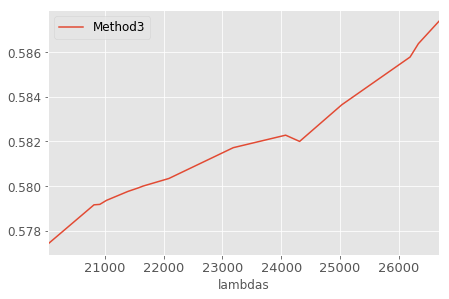

In [22]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')

## Init the writer with 15 $\lambda$'s from (2.5, 3.5)

In [10]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/sh_15lmbdas_ar1_3lyrs_he1_35_55', sess.graph)

### Generate $\lambda$s

In [11]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=3.5, high=5.5, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = a.tolist()*n_reps
print(a, len(a))

[4.58680988 4.05673877 4.34903518 5.18955226 3.50943771 3.74313824
 4.84149817 5.15170551 3.77341318 4.65018666 5.28264391 3.91840424
 3.87065644 3.71675378 3.93939499]
()
[35094.37712382 37167.53780929 37431.38241566 37734.1317937
 38706.564391   39184.04244234 39393.9498525  40567.38770188
 43490.35181498 45868.09883582 46501.86658854 48414.98169454
 51517.0551021  51895.5226464  52826.43908625]
()
([35094.37712381945, 37167.5378092851, 37431.38241566229, 37734.13179369906, 38706.564391001506, 39184.042442343794, 39393.94985249984, 40567.38770187592, 43490.351814982656, 45868.098835819306, 46501.866588544995, 48414.98169453558, 51517.05510210095, 51895.52264639808, 52826.43908624528, 35094.37712381945, 37167.5378092851, 37431.38241566229, 37734.13179369906, 38706.564391001506, 39184.042442343794, 39393.94985249984, 40567.38770187592, 43490.351814982656, 45868.098835819306, 46501.866588544995, 48414.98169453558, 51517.05510210095, 51895.52264639808, 52826.43908624528, 35094.3771238194

### Generate random weights

In [13]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(75, 75)


In [14]:
np.array_equal(np_weights[0], np_weights[14])

True

In [15]:
np.array_equal(np_weights[0], np_weights[15])

False

### Commence training

In [16]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:35094.3771238, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.110008373857 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0464498177171 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0302495043725 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0230062417686 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0189097225666 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0162695497274 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0144200399518 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0130483405665 and training accuracy:

training cost:0.0302495043725 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0230062417686 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0189097225666 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0162695497274 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0144200399518 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0130483405665 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0119868498296 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0111383758485 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0104427644983 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.00986076705158 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0093653537333 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0089377630502 and training 

training cost:0.0119868498296 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0111383758485 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0104427644983 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.00986076705158 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0093653537333 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0089377630502 and training accuracy:0.998004496098
Training on :(0, 1)
Time taken:64.4184319973
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.254414379597 and training accuracy:0.945004999638
Training on :(2, 3)
training cost:0.168301045895 and training accuracy:0.953640580177
Trainin

Time taken:64.2627410889
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.254421532154 and training accuracy:0.945004999638
Training on :(2, 3)
training cost:0.1683113873 and training accuracy:0.953640580177
Training on :(2, 3)
training cost:0.138406187296 and training accuracy:0.96054905653
Training on :(2, 3)
training cost:0.122964061797 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.11340457201 and training accuracy:0.964821398258
Training on :(2, 3)
training cost:0.106821678579 and training accuracy:0.966730296612
Training on :(2, 3)
training cost:0.101958073676 and training accuracy:0.968002915382
Training on :(2, 3)
training cost:0.0981806144118 and training accuracy:0.969002842903
Training on :(2, 

training cost:0.138442933559 and training accuracy:0.96054905653
Training on :(2, 3)
training cost:0.123001381755 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.113441437483 and training accuracy:0.964821398258
Training on :(2, 3)
training cost:0.106857903302 and training accuracy:0.966730296612
Training on :(2, 3)
training cost:0.101992972195 and training accuracy:0.968002915382
Training on :(2, 3)
training cost:0.0982142910361 and training accuracy:0.969002842903
Training on :(2, 3)
training cost:0.0951683968306 and training accuracy:0.969639122486
Training on :(2, 3)
training cost:0.0926391705871 and training accuracy:0.970002710819
Training on :(2, 3)
training cost:0.0904893130064 and training accuracy:0.970275402069
Training on :(2, 3)
training cost:0.0886252000928 and training accuracy:0.970275402069
Training on :(2, 3)
training cost:0.0869814157486 and training accuracy:0.970911741257
Training on :(2, 3)
training cost:0.0855106860399 and training accura

training cost:0.0951847136021 and training accuracy:0.969639122486
Training on :(2, 3)
training cost:0.0926549062133 and training accuracy:0.970002710819
Training on :(2, 3)
training cost:0.0905043929815 and training accuracy:0.970275402069
Training on :(2, 3)
training cost:0.0886397361755 and training accuracy:0.970184504986
Training on :(2, 3)
training cost:0.0869954302907 and training accuracy:0.970911741257
Training on :(2, 3)
training cost:0.085524238646 and training accuracy:0.971638917923
Training on :(2, 3)
Time taken:61.3231229782
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.260378479958 and training accuracy:0.956195116043
Training on :(4, 5)
training cost:0.156916320324 and training accuracy:0.971121966839
Training 

Time taken:60.9218578339
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.26040995121 and training accuracy:0.956195116043
Training on :(4, 5)
training cost:0.156949579716 and training accuracy:0.971121966839
Training on :(4, 5)
training cost:0.11716966331 and training accuracy:0.977658510208
Training on :(4, 5)
training cost:0.0963084772229 and training accuracy:0.980975627899
Training on :(4, 5)
training cost:0.0834650471807 and training accuracy:0.983707308769
Training on :(4, 5)
training cost:0.0747357606888 and training accuracy:0.985560953617
Training on :(4, 5)
training cost:0.0683860257268 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0635337010026 and training accuracy:0.986829280853
Training on

training cost:0.117344655097 and training accuracy:0.977658510208
Training on :(4, 5)
training cost:0.0964677110314 and training accuracy:0.980975627899
Training on :(4, 5)
training cost:0.0836098119617 and training accuracy:0.983707308769
Training on :(4, 5)
training cost:0.074867144227 and training accuracy:0.985560953617
Training on :(4, 5)
training cost:0.0685060396791 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0636437162757 and training accuracy:0.986829280853
Training on :(4, 5)
training cost:0.05978724733 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0566399358213 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.0540119819343 and training accuracy:0.987902462482
Training on :(4, 5)
training cost:0.0517741404474 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.049837693572 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0481403395534 and training accur

training cost:0.0600331090391 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0568694844842 and training accuracy:0.987609744072
Training on :(4, 5)
training cost:0.054226860404 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0519765727222 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0500287674367 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0483212172985 and training accuracy:0.988682925701
Training on :(4, 5)
Time taken:56.4838130474
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.115370795131 and training accuracy:0.995580434799
Training on :(6, 7)
training cost:0.0646215826273 and training accuracy:0.996211767197
Training

Time taken:56.9909129143
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.115839168429 and training accuracy:0.995580434799
Training on :(6, 7)
training cost:0.0649988353252 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.0481300652027 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0395354181528 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0342169031501 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0305422842503 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0278186835349 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0256989225745 and training accuracy:0.997113764286
Trainin

training cost:0.0482147410512 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0396097786725 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0342832356691 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0306021235883 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0278733503073 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0257490128279 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0240359101444 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0226172115654 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.021417291835 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0203849244863 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0194844398648 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0186899751425 and training a

training cost:0.0241735987365 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.02274556458 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0215374305844 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0204980932176 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0195914208889 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.018791789189 and training accuracy:0.997654914856
Training on :(6, 7)
Time taken:61.9318161011
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.212602064013 and training accuracy:0.957534015179
Training on :(8, 9)
training cost:0.148895353079 and training accuracy:0.963214755058
Training on

Time taken:61.9128818512
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.213500142097 and training accuracy:0.957627117634
Training on :(8, 9)
training cost:0.149562999606 and training accuracy:0.963214755058
Training on :(8, 9)
training cost:0.125919431448 and training accuracy:0.965542912483
Training on :(8, 9)
training cost:0.112848833203 and training accuracy:0.967964231968
Training on :(8, 9)
training cost:0.104186408222 and training accuracy:0.970106184483
Training on :(8, 9)
training cost:0.0978563725948 and training accuracy:0.971503078938
Training on :(8, 9)
training cost:0.0929434224963 and training accuracy:0.972341239452
Training on :(8, 9)
training cost:0.0889757573605 and training accuracy:0.973458766937
Training on

training cost:0.125986605883 and training accuracy:0.965542912483
Training on :(8, 9)
training cost:0.112908422947 and training accuracy:0.967964231968
Training on :(8, 9)
training cost:0.104240678251 and training accuracy:0.970106184483
Training on :(8, 9)
training cost:0.0979065746069 and training accuracy:0.971503078938
Training on :(8, 9)
training cost:0.0929906070232 and training accuracy:0.972341239452
Training on :(8, 9)
training cost:0.0890203937888 and training accuracy:0.973272502422
Training on :(8, 9)
training cost:0.0857158601284 and training accuracy:0.974110662937
Training on :(8, 9)
training cost:0.0829067528248 and training accuracy:0.974855661392
Training on :(8, 9)
training cost:0.0804739296436 and training accuracy:0.975600659847
Training on :(8, 9)
training cost:0.0783374011517 and training accuracy:0.976252555847
Training on :(8, 9)
training cost:0.0764384418726 and training accuracy:0.976531922817
Training on :(8, 9)
training cost:0.0747330412269 and training acc

training cost:0.0858200117946 and training accuracy:0.974110662937
Training on :(8, 9)
training cost:0.0830055400729 and training accuracy:0.974855661392
Training on :(8, 9)
training cost:0.0805692374706 and training accuracy:0.975600659847
Training on :(8, 9)
training cost:0.0784291327 and training accuracy:0.976252555847
Training on :(8, 9)
training cost:0.0765271410346 and training accuracy:0.976438820362
Training on :(8, 9)
training cost:0.0748190432787 and training accuracy:0.976718187332
Training on :(8, 9)
Time taken:60.785161972
Method 3 test accuracy:0.608200013638
Training with lmbda:35094.3771238, 15
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109210990369 and training accuracy:0.995748758316
Training on

Time taken:60.1222290993
Method 3 test accuracy:0.567600011826
Training with lmbda:37167.5378093, 16
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109210990369 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467881597579 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0307176131755 and training accuracy:0.996963381767
Training on :(0, 1)
training cost:0.0234973598272 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193961337209 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0167423952371 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0148768387735 and training accuracy:0.997657477856
Trainin

training cost:0.0467881597579 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0307176131755 and training accuracy:0.996963381767
Training on :(0, 1)
training cost:0.0234973598272 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193961337209 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0167423952371 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0148768387735 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0134880719706 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124092334881 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0115437982604 and training accuracy:0.997917771339
Training on :(0, 1)
training cost:0.0108319735155 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.0102344285697 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00972424540669 and training

training cost:0.0134880719706 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124092334881 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0115437982604 and training accuracy:0.997917771339
Training on :(0, 1)
training cost:0.0108319735155 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.0102344285697 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00972424540669 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00928265508264 and training accuracy:0.99809128046
Training on :(0, 1)
Time taken:65.0646791458
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260930478573 and training accuracy:0.944732308388
Traini

training cost:0.00928265508264 and training accuracy:0.99809128046
Training on :(0, 1)
Time taken:64.8707501888
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260955631733 and training accuracy:0.944732308388
Training on :(2, 3)
training cost:0.171188011765 and training accuracy:0.95427685976
Training on :(2, 3)
training cost:0.140261977911 and training accuracy:0.959912717342
Training on :(2, 3)
training cost:0.124435894191 and training accuracy:0.9629124403
Training on :(2, 3)
training cost:0.114674165845 and training accuracy:0.965366780758
Training on :(2, 3)
training cost:0.107964761555 and training accuracy:0.966912090778
Training on :(2, 3)
training cost:0.103007413447 and training accuracy:0.968184709549
Training on :(2,

training cost:0.171206176281 and training accuracy:0.95427685976
Training on :(2, 3)
training cost:0.140281960368 and training accuracy:0.959912717342
Training on :(2, 3)
training cost:0.124456629157 and training accuracy:0.9629124403
Training on :(2, 3)
training cost:0.114695087075 and training accuracy:0.965366780758
Training on :(2, 3)
training cost:0.107985369861 and training accuracy:0.966912090778
Training on :(2, 3)
training cost:0.103027366102 and training accuracy:0.968184709549
Training on :(2, 3)
training cost:0.0991666913033 and training accuracy:0.969730019569
Training on :(2, 3)
training cost:0.0960406064987 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.0934336483479 and training accuracy:0.971093535423
Training on :(2, 3)
training cost:0.0912085101008 and training accuracy:0.971729815006
Training on :(2, 3)
training cost:0.0892717242241 and training accuracy:0.971820771694
Training on :(2, 3)
training cost:0.0875572711229 and training accuracy:

training cost:0.0991752520204 and training accuracy:0.969730019569
Training on :(2, 3)
training cost:0.0960489064455 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.0934417098761 and training accuracy:0.971093535423
Training on :(2, 3)
training cost:0.0912163928151 and training accuracy:0.971729815006
Training on :(2, 3)
training cost:0.0892791077495 and training accuracy:0.971820771694
Training on :(2, 3)
training cost:0.0875644385815 and training accuracy:0.972457051277
Training on :(2, 3)
training cost:0.0860272496939 and training accuracy:0.972638845444
Training on :(2, 3)
Time taken:61.9069430828
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.256471663713 and training accuracy:0.958341479301
Trainin

training cost:0.0860663726926 and training accuracy:0.972638845444
Training on :(2, 3)
Time taken:62.2855768204
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.256652384996 and training accuracy:0.958439052105
Training on :(4, 5)
training cost:0.1542031914 and training accuracy:0.972195148468
Training on :(4, 5)
training cost:0.115041442215 and training accuracy:0.978829264641
Training on :(4, 5)
training cost:0.0945873782039 and training accuracy:0.982048809528
Training on :(4, 5)
training cost:0.0820386111736 and training accuracy:0.984195113182
Training on :(4, 5)
training cost:0.0735248699784 and training accuracy:0.985756099224
Training on :(4, 5)
training cost:0.0673375353217 and training accuracy:0.986146330833
Training on

training cost:0.154670372605 and training accuracy:0.972195148468
Training on :(4, 5)
training cost:0.115487709641 and training accuracy:0.978829264641
Training on :(4, 5)
training cost:0.0949939489365 and training accuracy:0.981951236725
Training on :(4, 5)
training cost:0.0824050456285 and training accuracy:0.984195113182
Training on :(4, 5)
training cost:0.0738563761115 and training accuracy:0.985951244831
Training on :(4, 5)
training cost:0.067639246583 and training accuracy:0.98604875803
Training on :(4, 5)
training cost:0.0628891140223 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.059121362865 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.0560441613197 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0534706301987 and training accuracy:0.988292694092
Training on :(4, 5)
training cost:0.0512780696154 and training accuracy:0.988585352898
Training on :(4, 5)
training cost:0.0493814237416 and training accur

training cost:0.0631057396531 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0593216940761 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.0562308505177 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0536463707685 and training accuracy:0.988292694092
Training on :(4, 5)
training cost:0.0514449253678 and training accuracy:0.988585352898
Training on :(4, 5)
training cost:0.0495406799018 and training accuracy:0.989170730114
Training on :(4, 5)
training cost:0.0478709861636 and training accuracy:0.98946338892
Training on :(4, 5)
Time taken:58.022203207
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.119462154806 and training accuracy:0.995309829712
Training 

training cost:0.0479110330343 and training accuracy:0.98946338892
Training on :(4, 5)
Time taken:57.9491510391
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.119593031704 and training accuracy:0.995309829712
Training on :(6, 7)
training cost:0.0670929774642 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0495964251459 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.0406543463469 and training accuracy:0.996482372284
Training on :(6, 7)
training cost:0.0351083651185 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0312728844583 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0284299496561 and training accuracy:0.997113764286
Training

training cost:0.0674063488841 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0498615503311 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.0408830493689 and training accuracy:0.996392190456
Training on :(6, 7)
training cost:0.0353102050722 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0314537100494 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0285941697657 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0263709258288 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0245816577226 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0231029316783 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0218552742153 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0207848548889 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0198536589742 and training 

training cost:0.0266059227288 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.024799624458 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0233066882938 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0220471099019 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0209663901478 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0200261231512 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0191987529397 and training accuracy:0.997835278511
Training on :(6, 7)
Time taken:62.8114237785
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.213822558522 and training accuracy:0.956882119179
Training

training cost:0.0192180965096 and training accuracy:0.997835278511
Training on :(6, 7)
Time taken:63.1948578358
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.213937267661 and training accuracy:0.956882119179
Training on :(8, 9)
training cost:0.151772305369 and training accuracy:0.961538434029
Training on :(8, 9)
training cost:0.128543198109 and training accuracy:0.964052915573
Training on :(8, 9)
training cost:0.115561209619 and training accuracy:0.966381072998
Training on :(8, 9)
training cost:0.106884554029 and training accuracy:0.968150496483
Training on :(8, 9)
training cost:0.100502066314 and training accuracy:0.969919919968
Training on :(8, 9)
training cost:0.0955208018422 and training accuracy:0.971503078938
Training on 

training cost:0.151968628168 and training accuracy:0.961538434029
Training on :(8, 9)
training cost:0.128707155585 and training accuracy:0.964052915573
Training on :(8, 9)
training cost:0.115708090365 and training accuracy:0.966381072998
Training on :(8, 9)
training cost:0.107018969953 and training accuracy:0.968150496483
Training on :(8, 9)
training cost:0.100627735257 and training accuracy:0.969919919968
Training on :(8, 9)
training cost:0.095639295876 and training accuracy:0.971503078938
Training on :(8, 9)
training cost:0.0915910005569 and training accuracy:0.972434341908
Training on :(8, 9)
training cost:0.0882097929716 and training accuracy:0.973458766937
Training on :(8, 9)
training cost:0.0853223502636 and training accuracy:0.974017500877
Training on :(8, 9)
training cost:0.082815438509 and training accuracy:0.974669396877
Training on :(8, 9)
training cost:0.0806102082133 and training accuracy:0.975693821907
Training on :(8, 9)
training cost:0.0786482766271 and training accurac

training cost:0.0870232507586 and training accuracy:0.972620606422
Training on :(8, 9)
training cost:0.0838660597801 and training accuracy:0.973365604877
Training on :(8, 9)
training cost:0.0811642706394 and training accuracy:0.974390029907
Training on :(8, 9)
training cost:0.0788137763739 and training accuracy:0.975135028362
Training on :(8, 9)
training cost:0.0767390727997 and training accuracy:0.975600659847
Training on :(8, 9)
training cost:0.0748875364661 and training accuracy:0.975973188877
Training on :(8, 9)
training cost:0.0732196196914 and training accuracy:0.976531922817
Training on :(8, 9)
Time taken:61.6250560284
Method 3 test accuracy:0.553900003433
Training with lmbda:37167.5378093, 31
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Traini

training cost:0.0734571665525 and training accuracy:0.976438820362
Training on :(8, 9)
Time taken:61.1568160057
Method 3 test accuracy:0.555499970913
Training with lmbda:37431.3824157, 32
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.108751513064 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467011146247 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0306682921946 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.023459430784 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193667355925 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0167201757431 and training accuracy:0.997483968735
Training

Training on :(0, 1)
training cost:0.108751513064 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467011146247 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0306682921946 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.023459430784 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193667355925 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0167201757431 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0148603999987 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0134757561609 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124004138634 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0115378955379 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.010828259401 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0102326646

training cost:0.0148603999987 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0134757561609 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124004138634 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0115378955379 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.010828259401 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0102326646447 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00972426123917 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00928423460573 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:65.6451880932
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Train

training cost:0.00972426123917 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00928423460573 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:65.724807024
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.271703153849 and training accuracy:0.945368587971
Training on :(2, 3)
training cost:0.174213677645 and training accuracy:0.955094993114
Training on :(2, 3)
training cost:0.14153636992 and training accuracy:0.959367334843
Training on :(2, 3)
training cost:0.125095143914 and training accuracy:0.963366985321
Training on :(2, 3)
training cost:0.115059323609 and training accuracy:0.965912163258
Training on :(2, 3)
training cost:0.108205117285 and training accuracy:0.966548502445
Training on 

Training on :(2, 3)
training cost:0.271708577871 and training accuracy:0.945368587971
Training on :(2, 3)
training cost:0.174221351743 and training accuracy:0.955094993114
Training on :(2, 3)
training cost:0.141544565558 and training accuracy:0.959367334843
Training on :(2, 3)
training cost:0.125103279948 and training accuracy:0.963366985321
Training on :(2, 3)
training cost:0.115067385137 and training accuracy:0.965912163258
Training on :(2, 3)
training cost:0.108212962747 and training accuracy:0.966548502445
Training on :(2, 3)
training cost:0.103166200221 and training accuracy:0.967093884945
Training on :(2, 3)
training cost:0.0992525145411 and training accuracy:0.968457400799
Training on :(2, 3)
training cost:0.0960952267051 and training accuracy:0.968820989132
Training on :(2, 3)
training cost:0.0934702381492 and training accuracy:0.969820916653
Training on :(2, 3)
training cost:0.0912344753742 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.0892900750041 

training cost:0.103209257126 and training accuracy:0.967093884945
Training on :(2, 3)
training cost:0.0992943719029 and training accuracy:0.968366503716
Training on :(2, 3)
training cost:0.0961358323693 and training accuracy:0.968820989132
Training on :(2, 3)
training cost:0.0935096740723 and training accuracy:0.969820916653
Training on :(2, 3)
training cost:0.0912724435329 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.0893271267414 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0876065567136 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0860648974776 and training accuracy:0.97154802084
Training on :(2, 3)
Time taken:62.6437661648
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training o

training cost:0.0876928195357 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0861482322216 and training accuracy:0.97154802084
Training on :(2, 3)
Time taken:61.9041380882
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.2679643929 and training accuracy:0.952195107937
Training on :(4, 5)
training cost:0.162792116404 and training accuracy:0.969463407993
Training on :(4, 5)
training cost:0.122350014746 and training accuracy:0.97580486536
Training on :(4, 5)
training cost:0.100994057953 and training accuracy:0.980195105076
Training on :(4, 5)
training cost:0.0877583697438 and training accuracy:0.982731699944
Training on :(4, 5)
training cost:0.0787086039782 and training accuracy:0.984292685986
Training on :(4

Training on :(4, 5)
training cost:0.268340498209 and training accuracy:0.952487826347
Training on :(4, 5)
training cost:0.163199573755 and training accuracy:0.969463407993
Training on :(4, 5)
training cost:0.122738078237 and training accuracy:0.97580486536
Training on :(4, 5)
training cost:0.101349979639 and training accuracy:0.980195105076
Training on :(4, 5)
training cost:0.0880817323923 and training accuracy:0.982731699944
Training on :(4, 5)
training cost:0.0790040344 and training accuracy:0.984292685986
Training on :(4, 5)
training cost:0.0723609477282 and training accuracy:0.985170722008
Training on :(4, 5)
training cost:0.0672612041235 and training accuracy:0.98604875803
Training on :(4, 5)
training cost:0.0632018595934 and training accuracy:0.986634135246
Training on :(4, 5)
training cost:0.059876665473 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0570912361145 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0547150820494 and

training cost:0.0724316909909 and training accuracy:0.985170722008
Training on :(4, 5)
training cost:0.0673260614276 and training accuracy:0.98604875803
Training on :(4, 5)
training cost:0.0632622167468 and training accuracy:0.986634135246
Training on :(4, 5)
training cost:0.0599329397082 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0571438595653 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0547644048929 and training accuracy:0.987317085266
Training on :(4, 5)
training cost:0.0527034066617 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.0508950613439 and training accuracy:0.987707316875
Training on :(4, 5)
Time taken:57.7994110584
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Trainin

training cost:0.0528409406543 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.0510263442993 and training accuracy:0.987707316875
Training on :(4, 5)
Time taken:56.4254560471
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.117042779922 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0652499869466 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0480776242912 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0393067374825 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0338691882789 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0301097985357 and training accuracy:0.997564733028
Trainin

Training on :(6, 7)
training cost:0.117634139955 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0657232329249 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0484716817737 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0396443754435 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0341648943722 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0303737428039 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0275632310659 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0253781825304 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.023619569838 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0221659187227 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0209397953004 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.019887490

training cost:0.027591496706 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0254038982093 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0236432086676 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0221879519522 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0209604389966 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0199067592621 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0189898982644 and training accuracy:0.997925519943
Training on :(6, 7)
training cost:0.0181830264628 and training accuracy:0.998015701771
Training on :(6, 7)
Time taken:63.6185688972
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Trainin

training cost:0.0190347377211 and training accuracy:0.997925519943
Training on :(6, 7)
training cost:0.018225537613 and training accuracy:0.998015701771
Training on :(6, 7)
Time taken:62.9904060364
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.208052515984 and training accuracy:0.960979700089
Training on :(8, 9)
training cost:0.147206664085 and training accuracy:0.963028490543
Training on :(8, 9)
training cost:0.124769032001 and training accuracy:0.965636074543
Training on :(8, 9)
training cost:0.112304598093 and training accuracy:0.967405498028
Training on :(8, 9)
training cost:0.103993162513 and training accuracy:0.968709230423
Training on :(8, 9)
training cost:0.0978744849563 and training accuracy:0.969826757908
Training on 

Training on :(8, 9)
training cost:0.210505992174 and training accuracy:0.957720220089
Training on :(8, 9)
training cost:0.148140788078 and training accuracy:0.961910963058
Training on :(8, 9)
training cost:0.125046908855 and training accuracy:0.964891016483
Training on :(8, 9)
training cost:0.112260013819 and training accuracy:0.967498600483
Training on :(8, 9)
training cost:0.103769041598 and training accuracy:0.968895494938
Training on :(8, 9)
training cost:0.0975497886539 and training accuracy:0.970571815968
Training on :(8, 9)
training cost:0.092715755105 and training accuracy:0.971875607967
Training on :(8, 9)
training cost:0.08880405128 and training accuracy:0.973644971848
Training on :(8, 9)
training cost:0.0855422988534 and training accuracy:0.974483132362
Training on :(8, 9)
training cost:0.0827630460262 and training accuracy:0.975135028362
Training on :(8, 9)
training cost:0.0803559720516 and training accuracy:0.975786924362
Training on :(8, 9)
training cost:0.0782408341765 a

training cost:0.0930507555604 and training accuracy:0.971875607967
Training on :(8, 9)
training cost:0.0891234055161 and training accuracy:0.973644971848
Training on :(8, 9)
training cost:0.0858489200473 and training accuracy:0.974390029907
Training on :(8, 9)
training cost:0.0830589234829 and training accuracy:0.974855661392
Training on :(8, 9)
training cost:0.0806409791112 and training accuracy:0.975786924362
Training on :(8, 9)
training cost:0.0785150751472 and training accuracy:0.976252555847
Training on :(8, 9)
training cost:0.0766238942742 and training accuracy:0.976625084877
Training on :(8, 9)
training cost:0.0749236643314 and training accuracy:0.976904451847
Training on :(8, 9)
Time taken:60.329305172
Method 3 test accuracy:0.606999993324
Training with lmbda:37431.3824157, 47
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels

training cost:0.0766573920846 and training accuracy:0.976625084877
Training on :(8, 9)
training cost:0.0749560371041 and training accuracy:0.976904451847
Training on :(8, 9)
Time taken:60.417940855
Method 3 test accuracy:0.607100009918
Training with lmbda:37734.1317937, 48
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.111068069935 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0471392162144 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0308596212417 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.0235807783902 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0194607246667 and training accuracy:0.997397184372
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.111068069935 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0471392162144 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0308596212417 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.0235807783902 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0194607246667 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0168019216508 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0149351535365 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0135461715981 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0124680222943 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0116031467915 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0108915325254 and tra

training cost:0.0168019216508 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0149351535365 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0135461715981 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0124680222943 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0116031467915 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0108915325254 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0102940537035 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.00978401023895 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00934234075248 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:64.3121809959
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length o

training cost:0.0102940537035 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.00978401023895 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00934234075248 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:64.2930130959
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.267798602581 and training accuracy:0.946913897991
Training on :(2, 3)
training cost:0.173332825303 and training accuracy:0.954822301865
Training on :(2, 3)
training cost:0.141256421804 and training accuracy:0.959549129009
Training on :(2, 3)
training cost:0.124930977821 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.114889033139 and training accuracy:0.965730369091
Training 

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.267830252647 and training accuracy:0.946913897991
Training on :(2, 3)
training cost:0.173379212618 and training accuracy:0.954822301865
Training on :(2, 3)
training cost:0.141307473183 and training accuracy:0.959549129009
Training on :(2, 3)
training cost:0.124982655048 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.114940576255 and training accuracy:0.965730369091
Training on :(2, 3)
training cost:0.108047991991 and training accuracy:0.966912090778
Training on :(2, 3)
training cost:0.102963961661 and training accuracy:0.967821121216
Training on :(2, 3)
training cost:0.0990205928683 and training accuracy:0.968457400799
Training on :(2, 3)
training cost:0.0958405658603 and training accuracy:0.969639122486
Training on :(2, 3)
training cost:0.0931978076696 and training accuracy:0.97072994709
Training on :(2, 3)
training cost:0.0909477546811 and training accuracy:0.9

training cost:0.108169987798 and training accuracy:0.966821193695
Training on :(2, 3)
training cost:0.103081837296 and training accuracy:0.967821121216
Training on :(2, 3)
training cost:0.0991337969899 and training accuracy:0.968457400799
Training on :(2, 3)
training cost:0.0959492623806 and training accuracy:0.969548225403
Training on :(2, 3)
training cost:0.0933028385043 and training accuracy:0.97072994709
Training on :(2, 3)
training cost:0.0910485982895 and training accuracy:0.970820844173
Training on :(2, 3)
training cost:0.0890930369496 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0873676463962 and training accuracy:0.971820771694
Training on :(2, 3)
training cost:0.0858193561435 and training accuracy:0.971729815006
Training on :(2, 3)
Time taken:62.8685429096
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of vali

training cost:0.0891692489386 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0874405354261 and training accuracy:0.971820771694
Training on :(2, 3)
training cost:0.0858895257115 and training accuracy:0.971729815006
Training on :(2, 3)
Time taken:61.7965619564
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.272374749184 and training accuracy:0.947707295418
Training on :(4, 5)
training cost:0.165907338262 and training accuracy:0.967512190342
Training on :(4, 5)
training cost:0.124399200082 and training accuracy:0.97580486536
Training on :(4, 5)
training cost:0.10232039541 and training accuracy:0.979804873466
Training on :(4, 5)
training cost:0.0885863304138 and training accuracy:0.981463432312
Training on :

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.272481948137 and training accuracy:0.947707295418
Training on :(4, 5)
training cost:0.166016861796 and training accuracy:0.967512190342
Training on :(4, 5)
training cost:0.124501146376 and training accuracy:0.97580486536
Training on :(4, 5)
training cost:0.102412194014 and training accuracy:0.979804873466
Training on :(4, 5)
training cost:0.0886682122946 and training accuracy:0.981463432312
Training on :(4, 5)
training cost:0.079263292253 and training accuracy:0.983219504356
Training on :(4, 5)
training cost:0.072392873466 and training accuracy:0.984780490398
Training on :(4, 5)
training cost:0.0671297758818 and training accuracy:0.985560953617
Training on :(4, 5)
training cost:0.0629510730505 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0595388114452 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0566877014935 and training accuracy:0.

training cost:0.079484000802 and training accuracy:0.983219504356
Training on :(4, 5)
training cost:0.0725954920053 and training accuracy:0.984780490398
Training on :(4, 5)
training cost:0.0673171058297 and training accuracy:0.985560953617
Training on :(4, 5)
training cost:0.063125193119 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0597006008029 and training accuracy:0.987121939659
Training on :(4, 5)
training cost:0.0568402558565 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.054405298084 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0523013547063 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0504587590694 and training accuracy:0.988390266895
Training on :(4, 5)
Time taken:57.665430069
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of vali

training cost:0.0546295717359 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0525139346719 and training accuracy:0.988195121288
Training on :(4, 5)
training cost:0.0506606549025 and training accuracy:0.988390266895
Training on :(4, 5)
Time taken:56.6962490082
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.126503199339 and training accuracy:0.99467843771
Training on :(6, 7)
training cost:0.0697277784348 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0512654297054 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.0419598184526 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.0362312756479 and training accuracy:0.996843159199
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.126583978534 and training accuracy:0.99467843771
Training on :(6, 7)
training cost:0.0697928071022 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0513207502663 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.0420080348849 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.0362740345299 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0323211960495 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0293936245143 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.027115656063 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0252786446363 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0237574893981 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0224710721523 and training accurac

training cost:0.0324150845408 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0294785816222 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0271931663156 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0253501739353 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0238236282021 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0225329529494 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0214227177203 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0204547792673 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0196015592664 and training accuracy:0.997654914856
Training on :(6, 7)
Time taken:62.6014120579
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of 

training cost:0.0195408444852 and training accuracy:0.998196065426
Training on :(6, 7)
training cost:0.0186611730605 and training accuracy:0.998196065426
Training on :(6, 7)
training cost:0.0178870968521 and training accuracy:0.998286306858
Training on :(6, 7)
Time taken:62.9929990768
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.205262929201 and training accuracy:0.959582805634
Training on :(8, 9)
training cost:0.145359098911 and training accuracy:0.963028490543
Training on :(8, 9)
training cost:0.123140186071 and training accuracy:0.965542912483
Training on :(8, 9)
training cost:0.110803157091 and training accuracy:0.967405498028
Training on :(8, 9)
training cost:0.102593198419 and training accuracy:0.969733655453
Training on

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.205970197916 and training accuracy:0.959489643574
Training on :(8, 9)
training cost:0.145866364241 and training accuracy:0.963028490543
Training on :(8, 9)
training cost:0.1235807091 and training accuracy:0.965636074543
Training on :(8, 9)
training cost:0.11120557785 and training accuracy:0.967405498028
Training on :(8, 9)
training cost:0.102969102561 and training accuracy:0.969547390938
Training on :(8, 9)
training cost:0.0969256684184 and training accuracy:0.970944285393
Training on :(8, 9)
training cost:0.0922157168388 and training accuracy:0.971968710423
Training on :(8, 9)
training cost:0.0883974805474 and training accuracy:0.972713708878
Training on :(8, 9)
training cost:0.0852107703686 and training accuracy:0.973924398422
Training on :(8, 9)
training cost:0.0824927389622 and training accuracy:0.974669396877
Training on :(8, 9)
training cost:0.0801338925958 and training accuracy:0.9

training cost:0.0969707518816 and training accuracy:0.971037447453
Training on :(8, 9)
training cost:0.0922593846917 and training accuracy:0.971968710423
Training on :(8, 9)
training cost:0.0884394496679 and training accuracy:0.972620606422
Training on :(8, 9)
training cost:0.085251018405 and training accuracy:0.973924398422
Training on :(8, 9)
training cost:0.0825318321586 and training accuracy:0.974762499332
Training on :(8, 9)
training cost:0.0801716372371 and training accuracy:0.975414395332
Training on :(8, 9)
training cost:0.0780925676227 and training accuracy:0.975880026817
Training on :(8, 9)
training cost:0.0762411206961 and training accuracy:0.976345717907
Training on :(8, 9)
training cost:0.0745747089386 and training accuracy:0.976811349392
Training on :(8, 9)
Time taken:60.8369038105
Method 3 test accuracy:0.596099972725
Training with lmbda:37734.1317937, 63
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(115

training cost:0.0781339108944 and training accuracy:0.975880026817
Training on :(8, 9)
training cost:0.0762812048197 and training accuracy:0.976345717907
Training on :(8, 9)
training cost:0.0746140256524 and training accuracy:0.976811349392
Training on :(8, 9)
Time taken:61.9001140594
Method 3 test accuracy:0.596099972725
Training with lmbda:38706.564391, 64
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109431102872 and training accuracy:0.995835483074
Training on :(0, 1)
training cost:0.0466699711978 and training accuracy:0.996529579163
Training on :(0, 1)
training cost:0.0305001605302 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0232550613582 and training accuracy:0.997310400009
Training 

Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109431102872 and training accuracy:0.995835483074
Training on :(0, 1)
training cost:0.0466699711978 and training accuracy:0.996529579163
Training on :(0, 1)
training cost:0.0305001605302 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0232550613582 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0191527474672 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0165057834238 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0146508533508 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0132729951292 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.012205356732 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0113510312513 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0106499856338 and train

training cost:0.0165057834238 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0146508533508 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0132729951292 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.012205356732 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0113510312513 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0106499856338 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0100626572967 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00956206023693 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00912946742028 and training accuracy:0.997917771339
Training on :(0, 1)
Time taken:65.1166789532
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of

training cost:0.0100626572967 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00956206023693 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00912946742028 and training accuracy:0.997917771339
Training on :(0, 1)
Time taken:65.8513009548
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260342359543 and training accuracy:0.943459689617
Training on :(2, 3)
training cost:0.171041622758 and training accuracy:0.954458713531
Training on :(2, 3)
training cost:0.14014659822 and training accuracy:0.960367262363
Training on :(2, 3)
training cost:0.124302461743 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.114508211613 and training accuracy:0.965366780758
Training o

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260410755873 and training accuracy:0.943459689617
Training on :(2, 3)
training cost:0.171142816544 and training accuracy:0.954458713531
Training on :(2, 3)
training cost:0.140258580446 and training accuracy:0.960367262363
Training on :(2, 3)
training cost:0.124417565763 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.11462379247 and training accuracy:0.965366780758
Training on :(2, 3)
training cost:0.107867017388 and training accuracy:0.967275679111
Training on :(2, 3)
training cost:0.102858237922 and training accuracy:0.968184709549
Training on :(2, 3)
training cost:0.0989481657743 and training accuracy:0.969002842903
Training on :(2, 3)
training cost:0.0957787036896 and training accuracy:0.969639122486
Training on :(2, 3)
training cost:0.0931334346533 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0908712893724 and training accuracy:0.9

training cost:0.107957437634 and training accuracy:0.967275679111
Training on :(2, 3)
training cost:0.102945938706 and training accuracy:0.968093812466
Training on :(2, 3)
training cost:0.0990329682827 and training accuracy:0.96891194582
Training on :(2, 3)
training cost:0.0958605930209 and training accuracy:0.969639122486
Training on :(2, 3)
training cost:0.0932123661041 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0909471139312 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0889734700322 and training accuracy:0.972002565861
Training on :(2, 3)
training cost:0.0872255265713 and training accuracy:0.972275257111
Training on :(2, 3)
training cost:0.0856564640999 and training accuracy:0.972729742527
Training on :(2, 3)
Time taken:65.2699739933
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of vali

training cost:0.0889928117394 and training accuracy:0.972002565861
Training on :(2, 3)
training cost:0.087243847549 and training accuracy:0.972275257111
Training on :(2, 3)
training cost:0.0856741815805 and training accuracy:0.972729742527
Training on :(2, 3)
Time taken:64.7463099957
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.26903539896 and training accuracy:0.948292672634
Training on :(4, 5)
training cost:0.164554357529 and training accuracy:0.968780517578
Training on :(4, 5)
training cost:0.12356235832 and training accuracy:0.97648781538
Training on :(4, 5)
training cost:0.101735331118 and training accuracy:0.980097532272
Training on :(4, 5)
training cost:0.0881704613566 and training accuracy:0.982439041138
Training on :(

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.269321531057 and training accuracy:0.948487818241
Training on :(4, 5)
training cost:0.16486209631 and training accuracy:0.968780517578
Training on :(4, 5)
training cost:0.123852811754 and training accuracy:0.97648781538
Training on :(4, 5)
training cost:0.101999461651 and training accuracy:0.980097532272
Training on :(4, 5)
training cost:0.088408999145 and training accuracy:0.982439041138
Training on :(4, 5)
training cost:0.0791052654386 and training accuracy:0.983902454376
Training on :(4, 5)
training cost:0.0723040103912 and training accuracy:0.985268294811
Training on :(4, 5)
training cost:0.0670934394002 and training accuracy:0.986146330833
Training on :(4, 5)
training cost:0.0629542469978 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0595712400973 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0567437112331 and training accuracy:0.

training cost:0.0794401839375 and training accuracy:0.983804881573
Training on :(4, 5)
training cost:0.0726078301668 and training accuracy:0.985268294811
Training on :(4, 5)
training cost:0.0673718899488 and training accuracy:0.986146330833
Training on :(4, 5)
training cost:0.063211068511 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0598095282912 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0569660179317 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.0545464716852 and training accuracy:0.987804889679
Training on :(4, 5)
training cost:0.052455380559 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0506239049137 and training accuracy:0.988097548485
Training on :(4, 5)
Time taken:59.1665148735
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of va

training cost:0.0545715913177 and training accuracy:0.987804889679
Training on :(4, 5)
training cost:0.0524794459343 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0506467223167 and training accuracy:0.988097548485
Training on :(4, 5)
Time taken:59.6537230015
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.11947260797 and training accuracy:0.995490193367
Training on :(6, 7)
training cost:0.0670582130551 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0496146194637 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0406697764993 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0351049825549 and training accuracy:0.997294127941
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.119651563466 and training accuracy:0.995400011539
Training on :(6, 7)
training cost:0.0671995580196 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0497308522463 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0407682470977 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0351904854178 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0313235111535 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0284538660198 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0262216180563 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0244241375476 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0229387804866 and training accuracy:0.997925519943
Training on :(6, 7)
training cost:0.0216856896877 and training accur

### Final accuracy

In [17]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('sh_15lmbdas_ar1_3lyrs_he1_35_55.csv')
final_test_acc

,Method3,lambdas
0,0.6017,35094.377124
1,0.6030,37167.537809
2,0.6032,37431.382416
3,0.6005,37734.131794
4,0.6009,38706.564391
5,0.6015,39184.042442
6,0.6017,39393.949852
7,0.6019,40567.387702
8,0.6037,43490.351815
9,0.6044,45868.098836


#### Groupby $\lambda$

In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

,Method3
lambdas,
35094.377124,0.58472
37167.537809,0.58616
37431.382416,0.58632
37734.131794,0.58668
38706.564391,0.58728
39184.042442,0.58774
39393.949852,0.58786
40567.387702,0.58912
43490.351815,0.58854


In [19]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

,Method3
lambdas,
35094.377124,0.022742
37167.537809,0.022578
37431.382416,0.022529
37734.131794,0.022824
38706.564391,0.022889
39184.042442,0.022855
39393.949852,0.022930
40567.387702,0.022258
43490.351815,0.026031


In [20]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

,Method3
lambdas,
35094.377124,0.6056
37167.537809,0.6070
37431.382416,0.6071
37734.131794,0.6109
38706.564391,0.6116
39184.042442,0.6119
39393.949852,0.6121
40567.387702,0.6126
43490.351815,0.6132


#### Plot

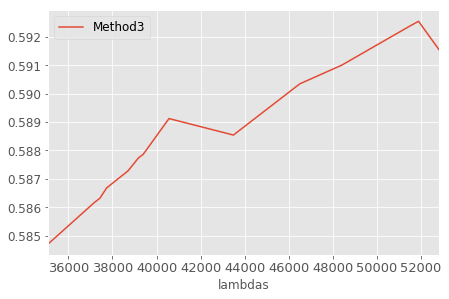

In [21]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')

## Init the writer with 16 more $\lambda$s from 3.5 to 7.5

In [10]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/sh_16lmbdas_ar1_3lyrs_he1_35_75', sess.graph)

### Generate $\lambda$s

In [11]:
np.random.seed(100)
n_lmbdas = 16
a = np.random.uniform(low=3.5, high=7.5, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = a.tolist()*n_reps
print(a, len(a))

[5.67361977 4.61347754 5.19807036 6.87910453 3.51887542 3.98627648
 6.18299634 6.80341102 4.04682636 5.80037332 7.06528782 4.33680849
 4.24131288 3.93350756 4.37878997 7.41449514]
()
[35188.75424764 39335.07561857 39862.76483132 40468.2635874
 42413.128782   43368.08488469 43787.899705   46134.77540375
 51980.70362997 56736.19767164 58003.73317709 61829.96338907
 68034.1102042  68791.0452928  70652.87817249 74144.95138829]
()
([35188.7542476389, 39335.075618570205, 39862.764831324566, 40468.26358739812, 42413.128782003005, 43368.08488468758, 43787.89970499968, 46134.77540375184, 51980.70362996532, 56736.19767163862, 58003.73317709, 61829.96338907115, 68034.1102042019, 68791.04529279615, 70652.87817249056, 74144.95138829478, 35188.7542476389, 39335.075618570205, 39862.764831324566, 40468.26358739812, 42413.128782003005, 43368.08488468758, 43787.89970499968, 46134.77540375184, 51980.70362996532, 56736.19767163862, 58003.73317709, 61829.96338907115, 68034.1102042019, 68791.04529279615, 70

### Generate random weights

In [12]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(80, 80)


In [13]:
np.array_equal(np_weights[0], np_weights[15])

True

In [14]:
np.array_equal(np_weights[0], np_weights[17])

False

### Commence training

In [15]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:35188.7542476, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.110008373857 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0464498177171 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0302495043725 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0230062417686 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0189097225666 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0162695497274 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0144200399518 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0130483405665 and training accuracy:

training cost:0.0302495043725 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0230062417686 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0189097225666 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0162695497274 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0144200399518 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0130483405665 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0119868498296 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0111383758485 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0104427644983 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.00986076705158 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0093653537333 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0089377630502 and training 

training cost:0.0119868498296 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0111383758485 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0104427644983 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.00986076705158 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0093653537333 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0089377630502 and training accuracy:0.998004496098
Training on :(0, 1)
Time taken:64.5023159981
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.254471570253 and training accuracy:0.945004999638
Training on :(2, 3)
training cost:0.16838426888 and training accuracy:0.953640580177
Training

Time taken:64.5487668514
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.254485785961 and training accuracy:0.945004999638
Training on :(2, 3)
training cost:0.168404787779 and training accuracy:0.953640580177
Training on :(2, 3)
training cost:0.138508722186 and training accuracy:0.96054905653
Training on :(2, 3)
training cost:0.123068422079 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.113507956266 and training accuracy:0.964821398258
Training on :(2, 3)
training cost:0.106922782958 and training accuracy:0.966730296612
Training on :(2, 3)
training cost:0.102055996656 and training accuracy:0.967912018299
Training on :(2, 3)
training cost:0.0982755571604 and training accuracy:0.969093739986
Training on :(

training cost:0.138580590487 and training accuracy:0.96054905653
Training on :(2, 3)
training cost:0.12314144522 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.113580524921 and training accuracy:0.964548707008
Training on :(2, 3)
training cost:0.106993846595 and training accuracy:0.966821193695
Training on :(2, 3)
training cost:0.102124325931 and training accuracy:0.967912018299
Training on :(2, 3)
training cost:0.0983418375254 and training accuracy:0.969093739986
Training on :(2, 3)
training cost:0.095291428268 and training accuracy:0.969548225403
Training on :(2, 3)
training cost:0.0927579775453 and training accuracy:0.970002710819
Training on :(2, 3)
training cost:0.0906036347151 and training accuracy:0.970275402069
Training on :(2, 3)
training cost:0.088735230267 and training accuracy:0.970184504986
Training on :(2, 3)
training cost:0.0870876535773 and training accuracy:0.970820844173
Training on :(2, 3)
training cost:0.0856128111482 and training accuracy:

training cost:0.0953223481774 and training accuracy:0.969548225403
Training on :(2, 3)
training cost:0.0927879959345 and training accuracy:0.970002710819
Training on :(2, 3)
training cost:0.090632148087 and training accuracy:0.970275402069
Training on :(2, 3)
training cost:0.0887625291944 and training accuracy:0.970184504986
Training on :(2, 3)
training cost:0.0871139317751 and training accuracy:0.970820844173
Training on :(2, 3)
training cost:0.0856381952763 and training accuracy:0.971638917923
Training on :(2, 3)
Time taken:61.4138188362
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.2610014081 and training accuracy:0.956195116043
Training on :(4, 5)
training cost:0.157568722963 and training accuracy:0.971121966839
Training on

Time taken:61.5873270035
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.26106107235 and training accuracy:0.956195116043
Training on :(4, 5)
training cost:0.157631337643 and training accuracy:0.971121966839
Training on :(4, 5)
training cost:0.117812238634 and training accuracy:0.977560997009
Training on :(4, 5)
training cost:0.0968916267157 and training accuracy:0.980878055096
Training on :(4, 5)
training cost:0.0839922130108 and training accuracy:0.983707308769
Training on :(4, 5)
training cost:0.0752151682973 and training accuracy:0.985658526421
Training on :(4, 5)
training cost:0.0688235834241 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0639350190759 and training accuracy:0.986829280853
Training o

training cost:0.118139222264 and training accuracy:0.977560997009
Training on :(4, 5)
training cost:0.0971873030066 and training accuracy:0.980878055096
Training on :(4, 5)
training cost:0.0842584595084 and training accuracy:0.983707308769
Training on :(4, 5)
training cost:0.0754562839866 and training accuracy:0.985658526421
Training on :(4, 5)
training cost:0.0690432935953 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0641376599669 and training accuracy:0.986829280853
Training on :(4, 5)
training cost:0.0602446570992 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0570671334863 and training accuracy:0.987609744072
Training on :(4, 5)
training cost:0.0544116459787 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0521496981382 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0501926913857 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0484764687717 and training a

training cost:0.060679782182 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0574721135199 and training accuracy:0.987609744072
Training on :(4, 5)
training cost:0.0547899566591 and training accuracy:0.987902462482
Training on :(4, 5)
training cost:0.052504196763 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0505259037018 and training accuracy:0.988487780094
Training on :(4, 5)
training cost:0.0487915575504 and training accuracy:0.988682925701
Training on :(4, 5)
Time taken:56.9861450195
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.11698731035 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.065919034183 and training accuracy:0.996211767197
Training on

Time taken:56.9774739742
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.117831148207 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0665912926197 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0494856275618 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0407183282077 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0352674163878 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.0314878746867 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.028678862378 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0264883767813 and training accuracy:0.997113764286
Training

training cost:0.0496310070157 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0408444069326 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0353787764907 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.0315876863897 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0287691820413 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0265712570399 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0247967615724 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0233258344233 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0220807269216 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.021009478718 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0200752671808 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0192515663803 and training a

training cost:0.0250200890005 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0235332511365 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0222745854408 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0211920998991 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0202481467277 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0194158740342 and training accuracy:0.997654914856
Training on :(6, 7)
Time taken:62.3993360996
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.216268986464 and training accuracy:0.957627117634
Training on :(8, 9)
training cost:0.151637241244 and training accuracy:0.962935388088
Training

Time taken:61.9909989834
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.217803806067 and training accuracy:0.957813382149
Training on :(8, 9)
training cost:0.15278890729 and training accuracy:0.962749123573
Training on :(8, 9)
training cost:0.128626927733 and training accuracy:0.965449810028
Training on :(8, 9)
training cost:0.115231998265 and training accuracy:0.967871129513
Training on :(8, 9)
training cost:0.106344364583 and training accuracy:0.969361126423
Training on :(8, 9)
training cost:0.0998458862305 and training accuracy:0.971130549908
Training on :(8, 9)
training cost:0.0948019251227 and training accuracy:0.972061812878
Training on :(8, 9)
training cost:0.0907261371613 and training accuracy:0.972806870937
Training on 

training cost:0.128740668297 and training accuracy:0.965449810028
Training on :(8, 9)
training cost:0.115330733359 and training accuracy:0.967871129513
Training on :(8, 9)
training cost:0.106433145702 and training accuracy:0.969361126423
Training on :(8, 9)
training cost:0.0999273434281 and training accuracy:0.971130549908
Training on :(8, 9)
training cost:0.0948783382773 and training accuracy:0.972061812878
Training on :(8, 9)
training cost:0.0907980725169 and training accuracy:0.972806870937
Training on :(8, 9)
training cost:0.0874044895172 and training accuracy:0.973924398422
Training on :(8, 9)
training cost:0.0845187008381 and training accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0820210054517 and training accuracy:0.975507557392
Training on :(8, 9)
training cost:0.0798281207681 and training accuracy:0.975880026817
Training on :(8, 9)
training cost:0.0778787732124 and training accuracy:0.976252555847
Training on :(8, 9)
training cost:0.0761272087693 and training acc

training cost:0.0875682979822 and training accuracy:0.973924398422
Training on :(8, 9)
training cost:0.0846749097109 and training accuracy:0.974483132362
Training on :(8, 9)
training cost:0.0821716189384 and training accuracy:0.975507557392
Training on :(8, 9)
training cost:0.079972922802 and training accuracy:0.975880026817
Training on :(8, 9)
training cost:0.0780179351568 and training accuracy:0.976252555847
Training on :(8, 9)
training cost:0.0762613266706 and training accuracy:0.976345717907
Training on :(8, 9)
Time taken:60.2690589428
Method 3 test accuracy:0.614400029182
Training with lmbda:74144.9513883, 15
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.110008373857 and training accuracy:0.995661973953
Training

Time taken:62.465503931
Method 3 test accuracy:0.615299999714
Training with lmbda:35188.7542476, 16
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109210990369 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467881597579 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0307176131755 and training accuracy:0.996963381767
Training on :(0, 1)
training cost:0.0234973598272 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193961337209 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0167423952371 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0148768387735 and training accuracy:0.997657477856
Training

training cost:0.0467881597579 and training accuracy:0.996616363525
Training on :(0, 1)
training cost:0.0307176131755 and training accuracy:0.996963381767
Training on :(0, 1)
training cost:0.0234973598272 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193961337209 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0167423952371 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0148768387735 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0134880719706 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124092334881 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0115437982604 and training accuracy:0.997917771339
Training on :(0, 1)
training cost:0.0108319735155 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.0102344285697 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00972424540669 and training

training cost:0.0134880719706 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124092334881 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0115437982604 and training accuracy:0.997917771339
Training on :(0, 1)
training cost:0.0108319735155 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.0102344285697 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00972424540669 and training accuracy:0.998004496098
Training on :(0, 1)
training cost:0.00928265508264 and training accuracy:0.99809128046
Training on :(0, 1)
Time taken:66.8119909763
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260985255241 and training accuracy:0.944732308388
Traini

training cost:0.00928265508264 and training accuracy:0.99809128046
Training on :(0, 1)
Time taken:66.3009300232
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.261000752449 and training accuracy:0.944732308388
Training on :(2, 3)
training cost:0.171254843473 and training accuracy:0.95427685976
Training on :(2, 3)
training cost:0.140335857868 and training accuracy:0.959912717342
Training on :(2, 3)
training cost:0.124512314796 and training accuracy:0.9629124403
Training on :(2, 3)
training cost:0.114750735462 and training accuracy:0.965366780758
Training on :(2, 3)
training cost:0.108040347695 and training accuracy:0.966912090778
Training on :(2, 3)
training cost:0.103080838919 and training accuracy:0.968184709549
Training on :(2,

training cost:0.171328261495 and training accuracy:0.95427685976
Training on :(2, 3)
training cost:0.140416964889 and training accuracy:0.960003614426
Training on :(2, 3)
training cost:0.124595738947 and training accuracy:0.9629124403
Training on :(2, 3)
training cost:0.114834062755 and training accuracy:0.965366780758
Training on :(2, 3)
training cost:0.108122184873 and training accuracy:0.966912090778
Training on :(2, 3)
training cost:0.103160366416 and training accuracy:0.968184709549
Training on :(2, 3)
training cost:0.0992959588766 and training accuracy:0.969730019569
Training on :(2, 3)
training cost:0.0961656421423 and training accuracy:0.97045725584
Training on :(2, 3)
training cost:0.0935546383262 and training accuracy:0.971093535423
Training on :(2, 3)
training cost:0.091326341033 and training accuracy:0.971638917923
Training on :(2, 3)
training cost:0.0893855392933 and training accuracy:0.971820771694
Training on :(2, 3)
training cost:0.0876671746373 and training accuracy:0.

training cost:0.0993335098028 and training accuracy:0.969730019569
Training on :(2, 3)
training cost:0.0962018147111 and training accuracy:0.97045725584
Training on :(2, 3)
training cost:0.0935896337032 and training accuracy:0.971093535423
Training on :(2, 3)
training cost:0.091360360384 and training accuracy:0.971638917923
Training on :(2, 3)
training cost:0.0894182771444 and training accuracy:0.971820771694
Training on :(2, 3)
training cost:0.0876989737153 and training accuracy:0.972457051277
Training on :(2, 3)
training cost:0.0861573144794 and training accuracy:0.972638845444
Training on :(2, 3)
Time taken:67.8890030384
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.257069945335 and training accuracy:0.958341479301
Training 

training cost:0.0861713886261 and training accuracy:0.972638845444
Training on :(2, 3)
Time taken:69.9549510479
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.257133364677 and training accuracy:0.958341479301
Training on :(4, 5)
training cost:0.154717922211 and training accuracy:0.972195148468
Training on :(4, 5)
training cost:0.115532919765 and training accuracy:0.978829264641
Training on :(4, 5)
training cost:0.0950345993042 and training accuracy:0.982048809528
Training on :(4, 5)
training cost:0.0824417993426 and training accuracy:0.984195113182
Training on :(4, 5)
training cost:0.0738895237446 and training accuracy:0.985951244831
Training on :(4, 5)
training cost:0.0676693767309 and training accuracy:0.98604875803
Training o

training cost:0.155080780387 and training accuracy:0.972292661667
Training on :(4, 5)
training cost:0.115876235068 and training accuracy:0.978829264641
Training on :(4, 5)
training cost:0.0953464210033 and training accuracy:0.982048809528
Training on :(4, 5)
training cost:0.0827225521207 and training accuracy:0.984195113182
Training on :(4, 5)
training cost:0.0741432085633 and training accuracy:0.985951244831
Training on :(4, 5)
training cost:0.0679003223777 and training accuracy:0.98604875803
Training on :(4, 5)
training cost:0.063129760325 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0593439824879 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.0562515482306 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0536658242345 and training accuracy:0.988292694092
Training on :(4, 5)
training cost:0.0514634437859 and training accuracy:0.988585352898
Training on :(4, 5)
training cost:0.0495587177575 and training accu

training cost:0.0636249259114 and training accuracy:0.987121939659
Training on :(4, 5)
training cost:0.0598033182323 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.0566815324128 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0540710017085 and training accuracy:0.988292694092
Training on :(4, 5)
training cost:0.0518478341401 and training accuracy:0.988682925701
Training on :(4, 5)
training cost:0.0499236509204 and training accuracy:0.989170730114
Training on :(4, 5)
training cost:0.0482363142073 and training accuracy:0.98946338892
Training on :(4, 5)
Time taken:61.3846430779
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.120683401823 and training accuracy:0.995129406452
Training

training cost:0.0484988167882 and training accuracy:0.989560961723
Training on :(4, 5)
Time taken:61.560669899
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.121590167284 and training accuracy:0.995039224625
Training on :(6, 7)
training cost:0.0686920583248 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0509387403727 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.0418073534966 and training accuracy:0.996392190456
Training on :(6, 7)
training cost:0.0361210927367 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0321785025299 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.029252614826 and training accuracy:0.997113764286
Training 

training cost:0.0688760429621 and training accuracy:0.995760798454
Training on :(6, 7)
training cost:0.0510915219784 and training accuracy:0.996211767197
Training on :(6, 7)
training cost:0.0419379025698 and training accuracy:0.996392190456
Training on :(6, 7)
training cost:0.0362353660166 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0322807654738 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0293452739716 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0270612984896 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0252219792455 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0237018503249 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0224189832807 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.0213178489357 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0203600078821 and training 

training cost:0.0273102466017 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0254528652877 and training accuracy:0.997113764286
Training on :(6, 7)
training cost:0.0239174254239 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0226219929755 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.021510289982 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0205427892506 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0196912419051 and training accuracy:0.997745096684
Training on :(6, 7)
Time taken:62.4525129795
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.216768726707 and training accuracy:0.956509590149
Training

training cost:0.0199550446123 and training accuracy:0.997654914856
Training on :(6, 7)
Time taken:62.7392048836
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.218407228589 and training accuracy:0.956509590149
Training on :(8, 9)
training cost:0.154968962073 and training accuracy:0.961445331573
Training on :(8, 9)
training cost:0.131194531918 and training accuracy:0.963773488998
Training on :(8, 9)
training cost:0.117897711694 and training accuracy:0.966008543968
Training on :(8, 9)
training cost:0.109017789364 and training accuracy:0.967591702938
Training on :(8, 9)
training cost:0.102486804128 and training accuracy:0.969454288483
Training on :(8, 9)
training cost:0.0973910018802 and training accuracy:0.970758080482
Training on 

training cost:0.155107691884 and training accuracy:0.961445331573
Training on :(8, 9)
training cost:0.131308436394 and training accuracy:0.963773488998
Training on :(8, 9)
training cost:0.117997340858 and training accuracy:0.965915441513
Training on :(8, 9)
training cost:0.109108291566 and training accuracy:0.967591702938
Training on :(8, 9)
training cost:0.102570667863 and training accuracy:0.969454288483
Training on :(8, 9)
training cost:0.0974693596363 and training accuracy:0.970758080482
Training on :(8, 9)
training cost:0.0933285802603 and training accuracy:0.972061812878
Training on :(8, 9)
training cost:0.0898685231805 and training accuracy:0.972993135452
Training on :(8, 9)
training cost:0.0869158133864 and training accuracy:0.973831236362
Training on :(8, 9)
training cost:0.0843520089984 and training accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0820955187082 and training accuracy:0.974855661392
Training on :(8, 9)
training cost:0.0800857171416 and training accur

training cost:0.0935121923685 and training accuracy:0.972061812878
Training on :(8, 9)
training cost:0.0900442004204 and training accuracy:0.972899973392
Training on :(8, 9)
training cost:0.0870847553015 and training accuracy:0.973831236362
Training on :(8, 9)
training cost:0.0845148786902 and training accuracy:0.974483132362
Training on :(8, 9)
training cost:0.0822524726391 and training accuracy:0.974855661392
Training on :(8, 9)
training cost:0.0802370756865 and training accuracy:0.975786924362
Training on :(8, 9)
training cost:0.0784244388342 and training accuracy:0.976159453392
Training on :(8, 9)
Time taken:60.3860211372
Method 3 test accuracy:0.587599992752
Training with lmbda:74144.9513883, 31
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Traini

training cost:0.0786855891347 and training accuracy:0.976066291332
Training on :(8, 9)
Time taken:60.3637881279
Method 3 test accuracy:0.588999986649
Training with lmbda:35188.7542476, 32
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.108751513064 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467011146247 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0306682921946 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.023459430784 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193667355925 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0167201757431 and training accuracy:0.997483968735
Training

Training on :(0, 1)
training cost:0.108751513064 and training accuracy:0.995748758316
Training on :(0, 1)
training cost:0.0467011146247 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0306682921946 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.023459430784 and training accuracy:0.997223675251
Training on :(0, 1)
training cost:0.0193667355925 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0167201757431 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0148603999987 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0134757561609 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124004138634 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0115378955379 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.010828259401 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0102326646

training cost:0.0148603999987 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0134757561609 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0124004138634 and training accuracy:0.997744202614
Training on :(0, 1)
training cost:0.0115378955379 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.010828259401 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0102326646447 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00972426123917 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00928423460573 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:64.6085479259
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Train

training cost:0.00972426123917 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00928423460573 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:64.593323946
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.27173653245 and training accuracy:0.945277690887
Training on :(2, 3)
training cost:0.17426083982 and training accuracy:0.955094993114
Training on :(2, 3)
training cost:0.141586393118 and training accuracy:0.959367334843
Training on :(2, 3)
training cost:0.125145375729 and training accuracy:0.963276088238
Training on :(2, 3)
training cost:0.115108862519 and training accuracy:0.965912163258
Training on :(2, 3)
training cost:0.108253389597 and training accuracy:0.966548502445
Training on :

Training on :(2, 3)
training cost:0.271786987782 and training accuracy:0.945277690887
Training on :(2, 3)
training cost:0.17433090508 and training accuracy:0.955094993114
Training on :(2, 3)
training cost:0.141661182046 and training accuracy:0.959367334843
Training on :(2, 3)
training cost:0.125220760703 and training accuracy:0.963276088238
Training on :(2, 3)
training cost:0.115183152258 and training accuracy:0.965912163258
Training on :(2, 3)
training cost:0.108325645328 and training accuracy:0.966548502445
Training on :(2, 3)
training cost:0.103275887668 and training accuracy:0.967093884945
Training on :(2, 3)
training cost:0.0993588864803 and training accuracy:0.968366503716
Training on :(2, 3)
training cost:0.0961983725429 and training accuracy:0.968820989132
Training on :(2, 3)
training cost:0.0935702398419 and training accuracy:0.969820916653
Training on :(2, 3)
training cost:0.0913309901953 and training accuracy:0.970366358757
Training on :(2, 3)
training cost:0.0893837288022 a

training cost:0.103309720755 and training accuracy:0.967093884945
Training on :(2, 3)
training cost:0.0993917733431 and training accuracy:0.968366503716
Training on :(2, 3)
training cost:0.0962300226092 and training accuracy:0.968820989132
Training on :(2, 3)
training cost:0.0936010628939 and training accuracy:0.969820916653
Training on :(2, 3)
training cost:0.091360732913 and training accuracy:0.970275402069
Training on :(2, 3)
training cost:0.0894121974707 and training accuracy:0.971184432507
Training on :(2, 3)
training cost:0.0876893252134 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0861449018121 and training accuracy:0.97154802084
Training on :(2, 3)
Time taken:61.6514971256
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training o

training cost:0.0877015143633 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0861567035317 and training accuracy:0.97154802084
Training on :(2, 3)
Time taken:61.7036130428
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.268011182547 and training accuracy:0.952195107937
Training on :(4, 5)
training cost:0.162843853235 and training accuracy:0.969463407993
Training on :(4, 5)
training cost:0.122399821877 and training accuracy:0.97580486536
Training on :(4, 5)
training cost:0.101039394736 and training accuracy:0.980195105076
Training on :(4, 5)
training cost:0.0877998843789 and training accuracy:0.982731699944
Training on :(4, 5)
training cost:0.078746445477 and training accuracy:0.984292685986
Training on :(

Training on :(4, 5)
training cost:0.268381029367 and training accuracy:0.952487826347
Training on :(4, 5)
training cost:0.163244307041 and training accuracy:0.969463407993
Training on :(4, 5)
training cost:0.122780300677 and training accuracy:0.975707292557
Training on :(4, 5)
training cost:0.101388722658 and training accuracy:0.980195105076
Training on :(4, 5)
training cost:0.0881173312664 and training accuracy:0.982731699944
Training on :(4, 5)
training cost:0.0790363326669 and training accuracy:0.984292685986
Training on :(4, 5)
training cost:0.0723907053471 and training accuracy:0.985170722008
Training on :(4, 5)
training cost:0.0672887042165 and training accuracy:0.98604875803
Training on :(4, 5)
training cost:0.0632273033261 and training accuracy:0.986634135246
Training on :(4, 5)
training cost:0.059900444001 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0571135133505 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.054736007005 

training cost:0.0730098262429 and training accuracy:0.985170722008
Training on :(4, 5)
training cost:0.0678590759635 and training accuracy:0.98604875803
Training on :(4, 5)
training cost:0.0637555792928 and training accuracy:0.986634135246
Training on :(4, 5)
training cost:0.0603915676475 and training accuracy:0.986829280853
Training on :(4, 5)
training cost:0.0575733855367 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0551693029702 and training accuracy:0.987317085266
Training on :(4, 5)
training cost:0.0530862361193 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.051259290427 and training accuracy:0.987512171268
Training on :(4, 5)
Time taken:57.3414011002
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training

training cost:0.0533943399787 and training accuracy:0.987512171268
Training on :(4, 5)
training cost:0.051550976932 and training accuracy:0.987512171268
Training on :(4, 5)
Time taken:57.2375650406
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.118589960039 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0664791241288 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.0490977875888 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0401789955795 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0346316210926 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.030789045617 and training accuracy:0.997564733028
Training 

Training on :(6, 7)
training cost:0.118812717497 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0666549280286 and training accuracy:0.996572554111
Training on :(6, 7)
training cost:0.049242682755 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0403021685779 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0347393006086 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0308848898858 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0280244871974 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0257991943508 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0240073855966 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0225265622139 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.021276826039 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0202041100

training cost:0.0282759517431 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0260287914425 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0242188181728 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0227226242423 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0214597564191 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0203757341951 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0194329377264 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0186036359519 and training accuracy:0.998015701771
Training on :(6, 7)
Time taken:62.3431510925
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Traini

training cost:0.0196762345731 and training accuracy:0.997745096684
Training on :(6, 7)
training cost:0.0188342239708 and training accuracy:0.997835278511
Training on :(6, 7)
Time taken:62.1130189896
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.211890012026 and training accuracy:0.960700333118
Training on :(8, 9)
training cost:0.149948865175 and training accuracy:0.963214755058
Training on :(8, 9)
training cost:0.127032458782 and training accuracy:0.965636074543
Training on :(8, 9)
training cost:0.114289268851 and training accuracy:0.967219233513
Training on :(8, 9)
training cost:0.105791009963 and training accuracy:0.968709230423
Training on :(8, 9)
training cost:0.0995391532779 and training accuracy:0.969826757908
Training on

Training on :(8, 9)
training cost:0.21206830442 and training accuracy:0.960700333118
Training on :(8, 9)
training cost:0.15007583797 and training accuracy:0.963214755058
Training on :(8, 9)
training cost:0.127136439085 and training accuracy:0.965636074543
Training on :(8, 9)
training cost:0.114380374551 and training accuracy:0.967219233513
Training on :(8, 9)
training cost:0.105872631073 and training accuracy:0.968709230423
Training on :(8, 9)
training cost:0.0996147543192 and training accuracy:0.969826757908
Training on :(8, 9)
training cost:0.0947267189622 and training accuracy:0.971037447453
Training on :(8, 9)
training cost:0.0907518342137 and training accuracy:0.971968710423
Training on :(8, 9)
training cost:0.0874256491661 and training accuracy:0.973086237907
Training on :(8, 9)
training cost:0.0845824405551 and training accuracy:0.973458766937
Training on :(8, 9)
training cost:0.0821083039045 and training accuracy:0.974483132362
Training on :(8, 9)
training cost:0.0799275562167 

training cost:0.0948954969645 and training accuracy:0.971037447453
Training on :(8, 9)
training cost:0.0909122377634 and training accuracy:0.971968710423
Training on :(8, 9)
training cost:0.087579227984 and training accuracy:0.972993135452
Training on :(8, 9)
training cost:0.0847289413214 and training accuracy:0.973272502422
Training on :(8, 9)
training cost:0.0822495296597 and training accuracy:0.974483132362
Training on :(8, 9)
training cost:0.0800640061498 and training accuracy:0.974948763847
Training on :(8, 9)
training cost:0.0781161189079 and training accuracy:0.975414395332
Training on :(8, 9)
training cost:0.0763609185815 and training accuracy:0.975973188877
Training on :(8, 9)
Time taken:60.5702841282
Method 3 test accuracy:0.513000011444
Training with lmbda:74144.9513883, 47
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels

training cost:0.0783605799079 and training accuracy:0.975414395332
Training on :(8, 9)
training cost:0.0766001716256 and training accuracy:0.975880026817
Training on :(8, 9)
Time taken:61.2207839489
Method 3 test accuracy:0.513100028038
Training with lmbda:35188.7542476, 48
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.111068069935 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0471392162144 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0308596212417 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.0235807783902 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0194607246667 and training accuracy:0.997397184372
Trainin

Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.111068069935 and training accuracy:0.995661973953
Training on :(0, 1)
training cost:0.0471392162144 and training accuracy:0.996356070042
Training on :(0, 1)
training cost:0.0308596212417 and training accuracy:0.996876597404
Training on :(0, 1)
training cost:0.0235807783902 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0194607246667 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0168019216508 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0149351535365 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0135461715981 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0124680222943 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0116031467915 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0108915325254 and tra

training cost:0.0168019216508 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0149351535365 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0135461715981 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0124680222943 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0116031467915 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.0108915325254 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0102940537035 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.00978401023895 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00934234075248 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:64.5225019455
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length o

training cost:0.0102940537035 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.00978401023895 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00934234075248 and training accuracy:0.997830986977
Training on :(0, 1)
Time taken:64.9598200321
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.267827600241 and training accuracy:0.946913897991
Training on :(2, 3)
training cost:0.173375278711 and training accuracy:0.954822301865
Training on :(2, 3)
training cost:0.141303136945 and training accuracy:0.959549129009
Training on :(2, 3)
training cost:0.124978207052 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.114936083555 and training accuracy:0.965730369091
Training 

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.267879843712 and training accuracy:0.946913897991
Training on :(2, 3)
training cost:0.173451781273 and training accuracy:0.954822301865
Training on :(2, 3)
training cost:0.141386508942 and training accuracy:0.959549129009
Training on :(2, 3)
training cost:0.125063419342 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.115020059049 and training accuracy:0.965639472008
Training on :(2, 3)
training cost:0.108125425875 and training accuracy:0.966821193695
Training on :(2, 3)
training cost:0.103039085865 and training accuracy:0.967821121216
Training on :(2, 3)
training cost:0.0990926846862 and training accuracy:0.968457400799
Training on :(2, 3)
training cost:0.0959098041058 and training accuracy:0.969639122486
Training on :(2, 3)
training cost:0.0932648479939 and training accuracy:0.97072994709
Training on :(2, 3)
training cost:0.0910121649504 and training accuracy:0.9

training cost:0.108165040612 and training accuracy:0.966821193695
Training on :(2, 3)
training cost:0.103077076375 and training accuracy:0.967821121216
Training on :(2, 3)
training cost:0.0991292521358 and training accuracy:0.968457400799
Training on :(2, 3)
training cost:0.095944903791 and training accuracy:0.969548225403
Training on :(2, 3)
training cost:0.0932987108827 and training accuracy:0.97072994709
Training on :(2, 3)
training cost:0.0910446494818 and training accuracy:0.970820844173
Training on :(2, 3)
training cost:0.0890890881419 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0873639285564 and training accuracy:0.971820771694
Training on :(2, 3)
training cost:0.0858156830072 and training accuracy:0.971729815006
Training on :(2, 3)
Time taken:61.8541069031
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid

training cost:0.0891023278236 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0873765125871 and training accuracy:0.971820771694
Training on :(2, 3)
training cost:0.0858278870583 and training accuracy:0.971729815006
Training on :(2, 3)
Time taken:61.9092741013
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.272024780512 and training accuracy:0.947707295418
Training on :(4, 5)
training cost:0.165543466806 and training accuracy:0.967609763145
Training on :(4, 5)
training cost:0.124059423804 and training accuracy:0.97580486536
Training on :(4, 5)
training cost:0.102013744414 and training accuracy:0.97990244627
Training on :(4, 5)
training cost:0.0883089676499 and training accuracy:0.981463432312
Training on :

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.272419810295 and training accuracy:0.947707295418
Training on :(4, 5)
training cost:0.165953502059 and training accuracy:0.967609763145
Training on :(4, 5)
training cost:0.124442130327 and training accuracy:0.97580486536
Training on :(4, 5)
training cost:0.102359473705 and training accuracy:0.979804873466
Training on :(4, 5)
training cost:0.0886210203171 and training accuracy:0.981463432312
Training on :(4, 5)
training cost:0.0792207196355 and training accuracy:0.983219504356
Training on :(4, 5)
training cost:0.0723536238074 and training accuracy:0.984780490398
Training on :(4, 5)
training cost:0.067093834281 and training accuracy:0.985560953617
Training on :(4, 5)
training cost:0.0629173964262 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.059507586062 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0566582642496 and training accuracy:0.

training cost:0.0798814743757 and training accuracy:0.983219504356
Training on :(4, 5)
training cost:0.0729587972164 and training accuracy:0.984682917595
Training on :(4, 5)
training cost:0.0676523298025 and training accuracy:0.985658526421
Training on :(4, 5)
training cost:0.063435792923 and training accuracy:0.986439049244
Training on :(4, 5)
training cost:0.0599909536541 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0571129657328 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.0546624325216 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0525448322296 and training accuracy:0.988195121288
Training on :(4, 5)
training cost:0.0506900623441 and training accuracy:0.988390266895
Training on :(4, 5)
Time taken:57.4533190727
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of v

training cost:0.0549831353128 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0528473928571 and training accuracy:0.988195121288
Training on :(4, 5)
training cost:0.0509758852422 and training accuracy:0.988292694092
Training on :(4, 5)
Time taken:57.3503668308
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.127584531903 and training accuracy:0.99467843771
Training on :(6, 7)
training cost:0.0706005468965 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0520086325705 and training accuracy:0.996121585369
Training on :(6, 7)
training cost:0.0426068454981 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0368033461273 and training accuracy:0.996843159199
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.127838388085 and training accuracy:0.99467843771
Training on :(6, 7)
training cost:0.0708044841886 and training accuracy:0.995670616627
Training on :(6, 7)
training cost:0.0521815642715 and training accuracy:0.996121585369
Training on :(6, 7)
training cost:0.0427570417523 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0369354039431 and training accuracy:0.996843159199
Training on :(6, 7)
training cost:0.0329124927521 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0299275983125 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0276026558131 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0257265046239 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0241720527411 and training accuracy:0.997564733028
Training on :(6, 7)
training cost:0.0228573773056 and training accura

training cost:0.0332579389215 and training accuracy:0.996933341026
Training on :(6, 7)
training cost:0.0302389040589 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0278857909143 and training accuracy:0.997203946114
Training on :(6, 7)
training cost:0.0259864423424 and training accuracy:0.997384309769
Training on :(6, 7)
training cost:0.0244127046317 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0230814926326 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0219364836812 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0209384001791 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0200581494719 and training accuracy:0.997654914856
Training on :(6, 7)
Time taken:62.9461507797
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of 

training cost:0.0222503058612 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0212334580719 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0203369390219 and training accuracy:0.997654914856
Training on :(6, 7)
Time taken:62.2807569504
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.220483705401 and training accuracy:0.957906484604
Training on :(8, 9)
training cost:0.155238837004 and training accuracy:0.961817860603
Training on :(8, 9)
training cost:0.131013199687 and training accuracy:0.964891016483
Training on :(8, 9)
training cost:0.117569342256 and training accuracy:0.967312335968
Training on :(8, 9)
training cost:0.108630053699 and training accuracy:0.968802392483
Training on

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.220672115684 and training accuracy:0.957906484604
Training on :(8, 9)
training cost:0.155376911163 and training accuracy:0.961817860603
Training on :(8, 9)
training cost:0.131127849221 and training accuracy:0.964891016483
Training on :(8, 9)
training cost:0.117670096457 and training accuracy:0.967405498028
Training on :(8, 9)
training cost:0.108720913529 and training accuracy:0.968802392483
Training on :(8, 9)
training cost:0.102161221206 and training accuracy:0.969919919968
Training on :(8, 9)
training cost:0.09705837816 and training accuracy:0.970944285393
Training on :(8, 9)
training cost:0.0929239019752 and training accuracy:0.971782445908
Training on :(8, 9)
training cost:0.0894765406847 and training accuracy:0.973179340363
Training on :(8, 9)
training cost:0.0865358263254 and training accuracy:0.974110662937
Training on :(8, 9)
training cost:0.0839849859476 and training accuracy:0.9

training cost:0.102364473045 and training accuracy:0.969826757908
Training on :(8, 9)
training cost:0.0972485542297 and training accuracy:0.970944285393
Training on :(8, 9)
training cost:0.0931035280228 and training accuracy:0.971689343452
Training on :(8, 9)
training cost:0.0896464660764 and training accuracy:0.973179340363
Training on :(8, 9)
training cost:0.0866972878575 and training accuracy:0.974017500877
Training on :(8, 9)
training cost:0.0841408744454 and training accuracy:0.974948763847
Training on :(8, 9)
training cost:0.081892311573 and training accuracy:0.975693821907
Training on :(8, 9)
training cost:0.0798903554678 and training accuracy:0.976159453392
Training on :(8, 9)
training cost:0.0780895873904 and training accuracy:0.976252555847
Training on :(8, 9)
Time taken:60.4116129875
Method 3 test accuracy:0.625
Training with lmbda:74144.9513883, 63
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
L

training cost:0.0821651667356 and training accuracy:0.975507557392
Training on :(8, 9)
training cost:0.0801533535123 and training accuracy:0.976159453392
Training on :(8, 9)
training cost:0.0783456340432 and training accuracy:0.976159453392
Training on :(8, 9)
Time taken:60.6126351357
Method 3 test accuracy:0.625500023365
Training with lmbda:35188.7542476, 64
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109431102872 and training accuracy:0.995835483074
Training on :(0, 1)
training cost:0.0466699711978 and training accuracy:0.996529579163
Training on :(0, 1)
training cost:0.0305001605302 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0232550613582 and training accuracy:0.997310400009
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
Training on :(0, 1)
training cost:0.109431102872 and training accuracy:0.995835483074
Training on :(0, 1)
training cost:0.0466699711978 and training accuracy:0.996529579163
Training on :(0, 1)
training cost:0.0305001605302 and training accuracy:0.99705016613
Training on :(0, 1)
training cost:0.0232550613582 and training accuracy:0.997310400009
Training on :(0, 1)
training cost:0.0191527474672 and training accuracy:0.997397184372
Training on :(0, 1)
training cost:0.0165057834238 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0146508533508 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0132729951292 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.012205356732 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0113510312513 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0106499856338 and train

training cost:0.0165057834238 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0146508533508 and training accuracy:0.997483968735
Training on :(0, 1)
training cost:0.0132729951292 and training accuracy:0.997570693493
Training on :(0, 1)
training cost:0.012205356732 and training accuracy:0.997657477856
Training on :(0, 1)
training cost:0.0113510312513 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0106499856338 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.0100626572967 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00956206023693 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00912946742028 and training accuracy:0.997917771339
Training on :(0, 1)
Time taken:64.7166910172
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of

training cost:0.0100626572967 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00956206023693 and training accuracy:0.997830986977
Training on :(0, 1)
training cost:0.00912946742028 and training accuracy:0.997917771339
Training on :(0, 1)
Time taken:64.6426999569
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 784)
Length of test labels:2042
Train features:(11001, 784)
Length of train labels:11001
Valid features:(1088, 784)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260340005159 and training accuracy:0.943459689617
Training on :(2, 3)
training cost:0.171038120985 and training accuracy:0.954458713531
Training on :(2, 3)
training cost:0.140142783523 and training accuracy:0.960367262363
Training on :(2, 3)
training cost:0.124298550189 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.114504247904 and training accuracy:0.965366780758
Training 

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(2, 3)
training cost:0.260385483503 and training accuracy:0.943459689617
Training on :(2, 3)
training cost:0.171105623245 and training accuracy:0.954458713531
Training on :(2, 3)
training cost:0.140217542648 and training accuracy:0.960458159447
Training on :(2, 3)
training cost:0.124375343323 and training accuracy:0.963457882404
Training on :(2, 3)
training cost:0.114581428468 and training accuracy:0.965366780758
Training on :(2, 3)
training cost:0.107825323939 and training accuracy:0.967275679111
Training on :(2, 3)
training cost:0.10281765461 and training accuracy:0.968184709549
Training on :(2, 3)
training cost:0.0989089757204 and training accuracy:0.969002842903
Training on :(2, 3)
training cost:0.0957410931587 and training accuracy:0.969639122486
Training on :(2, 3)
training cost:0.0930972397327 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0908360555768 and training accuracy:0.9

training cost:0.107862241566 and training accuracy:0.967275679111
Training on :(2, 3)
training cost:0.102853663266 and training accuracy:0.968184709549
Training on :(2, 3)
training cost:0.0989437550306 and training accuracy:0.969002842903
Training on :(2, 3)
training cost:0.0957744717598 and training accuracy:0.969639122486
Training on :(2, 3)
training cost:0.0931293144822 and training accuracy:0.969911813736
Training on :(2, 3)
training cost:0.0908673256636 and training accuracy:0.97127532959
Training on :(2, 3)
training cost:0.0888967365026 and training accuracy:0.971911668777
Training on :(2, 3)
training cost:0.087151452899 and training accuracy:0.972184360027
Training on :(2, 3)
training cost:0.0855854675174 and training accuracy:0.97282063961
Training on :(2, 3)
Time taken:61.9623270035
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid

training cost:0.088909804821 and training accuracy:0.971911668777
Training on :(2, 3)
training cost:0.0871640816331 and training accuracy:0.972184360027
Training on :(2, 3)
training cost:0.0855975449085 and training accuracy:0.97282063961
Training on :(2, 3)
Time taken:61.8962709904
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 784)
Length of test labels:1874
Train features:(10250, 784)
Length of train labels:10250
Valid features:(1013, 784)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.268622219563 and training accuracy:0.948195099831
Training on :(4, 5)
training cost:0.164104670286 and training accuracy:0.968780517578
Training on :(4, 5)
training cost:0.123135514557 and training accuracy:0.976390242577
Training on :(4, 5)
training cost:0.101346753538 and training accuracy:0.980097532272
Training on :(4, 5)
training cost:0.0878199860454 and training accuracy:0.982439041138
Training on 

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(4, 5)
training cost:0.268981665373 and training accuracy:0.948292672634
Training on :(4, 5)
training cost:0.164495006204 and training accuracy:0.968780517578
Training on :(4, 5)
training cost:0.123505450785 and training accuracy:0.97648781538
Training on :(4, 5)
training cost:0.101683557034 and training accuracy:0.980097532272
Training on :(4, 5)
training cost:0.0881240367889 and training accuracy:0.982439041138
Training on :(4, 5)
training cost:0.0788477361202 and training accuracy:0.983902454376
Training on :(4, 5)
training cost:0.0720696225762 and training accuracy:0.985268294811
Training on :(4, 5)
training cost:0.0668789744377 and training accuracy:0.986146330833
Training on :(4, 5)
training cost:0.062756344676 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0593878254294 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0565723180771 and training accuracy:0

training cost:0.0794890224934 and training accuracy:0.983804881573
Training on :(4, 5)
training cost:0.0726524144411 and training accuracy:0.985268294811
Training on :(4, 5)
training cost:0.0674124956131 and training accuracy:0.986146330833
Training on :(4, 5)
training cost:0.0632482022047 and training accuracy:0.986926853657
Training on :(4, 5)
training cost:0.0598439984024 and training accuracy:0.987219512463
Training on :(4, 5)
training cost:0.0569984279573 and training accuracy:0.987707316875
Training on :(4, 5)
training cost:0.0545771606266 and training accuracy:0.987804889679
Training on :(4, 5)
training cost:0.0524846725166 and training accuracy:0.988097548485
Training on :(4, 5)
training cost:0.0506517887115 and training accuracy:0.988097548485
Training on :(4, 5)
Time taken:56.7234909534
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of 

training cost:0.054878924042 and training accuracy:0.987804889679
Training on :(4, 5)
training cost:0.0527705922723 and training accuracy:0.987999975681
Training on :(4, 5)
training cost:0.0509241446853 and training accuracy:0.988097548485
Training on :(4, 5)
Time taken:57.7304069996
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 784)
Length of test labels:1986
Train features:(11087, 784)
Length of train labels:11087
Valid features:(1096, 784)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.120389811695 and training accuracy:0.995400011539
Training on :(6, 7)
training cost:0.0677786096931 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0502046570182 and training accuracy:0.996662735939
Training on :(6, 7)
training cost:0.0411681495607 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0355369225144 and training accuracy:0.997294127941
Training

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(6, 7)
training cost:0.120624624193 and training accuracy:0.995400011539
Training on :(6, 7)
training cost:0.0679607242346 and training accuracy:0.996301949024
Training on :(6, 7)
training cost:0.0503530725837 and training accuracy:0.996752977371
Training on :(6, 7)
training cost:0.0412930697203 and training accuracy:0.997023522854
Training on :(6, 7)
training cost:0.0356450006366 and training accuracy:0.997294127941
Training on :(6, 7)
training cost:0.031726475805 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0288169085979 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0265528056771 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0247296839952 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0232233293355 and training accuracy:0.997925519943
Training on :(6, 7)
training cost:0.0219526346773 and training accura

training cost:0.032003775239 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0290665142238 and training accuracy:0.997474491596
Training on :(6, 7)
training cost:0.0267803296447 and training accuracy:0.997654914856
Training on :(6, 7)
training cost:0.0249397922307 and training accuracy:0.997835278511
Training on :(6, 7)
training cost:0.0234188660979 and training accuracy:0.997925519943
Training on :(6, 7)
training cost:0.0221360679716 and training accuracy:0.997925519943
Training on :(6, 7)
training cost:0.0210359655321 and training accuracy:0.998015701771
Training on :(6, 7)
training cost:0.020079549402 and training accuracy:0.998196065426
Training on :(6, 7)
training cost:0.0192382950336 and training accuracy:0.998286306858
Training on :(6, 7)
Time taken:62.4498860836
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of va

training cost:0.0212975014001 and training accuracy:0.998015701771
Training on :(6, 7)
training cost:0.0203272663057 and training accuracy:0.998196065426
Training on :(6, 7)
training cost:0.0194737929851 and training accuracy:0.998286306858
Training on :(6, 7)
Time taken:66.7477850914
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 784)
Length of test labels:1983
Train features:(10738, 784)
Length of train labels:10738
Valid features:(1062, 784)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.214712560177 and training accuracy:0.958372116089
Training on :(8, 9)
training cost:0.152290314436 and training accuracy:0.962842226028
Training on :(8, 9)
training cost:0.129052966833 and training accuracy:0.964891016483
Training on :(8, 9)
training cost:0.116111956537 and training accuracy:0.966846704483
Training on :(8, 9)
training cost:0.107485681772 and training accuracy:0.968988656998
Training on

Repeat:0
training cost:2.30258536339 and training accuracy:0.0
Training on :(8, 9)
training cost:0.214896127582 and training accuracy:0.958372116089
Training on :(8, 9)
training cost:0.152425244451 and training accuracy:0.962842226028
Training on :(8, 9)
training cost:0.129165321589 and training accuracy:0.964891016483
Training on :(8, 9)
training cost:0.116211570799 and training accuracy:0.966939866543
Training on :(8, 9)
training cost:0.107576295733 and training accuracy:0.968988656998
Training on :(8, 9)
training cost:0.101241104305 and training accuracy:0.970478653908
Training on :(8, 9)
training cost:0.0963085219264 and training accuracy:0.971503078938
Training on :(8, 9)
training cost:0.0923096016049 and training accuracy:0.972154974937
Training on :(8, 9)
training cost:0.0889709293842 and training accuracy:0.972993135452
Training on :(8, 9)
training cost:0.0861227735877 and training accuracy:0.973738133907
Training on :(8, 9)
training cost:0.0836502164602 and training accuracy:0

training cost:0.10144816339 and training accuracy:0.970292448997
Training on :(8, 9)
training cost:0.0965031608939 and training accuracy:0.971503078938
Training on :(8, 9)
training cost:0.0924938246608 and training accuracy:0.972154974937
Training on :(8, 9)
training cost:0.0891478508711 and training accuracy:0.972899973392
Training on :(8, 9)
training cost:0.0862922519445 and training accuracy:0.973644971848
Training on :(8, 9)
training cost:0.0838143676519 and training accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0816319361329 and training accuracy:0.974948763847
Training on :(8, 9)
training cost:0.0796877071261 and training accuracy:0.975600659847
Training on :(8, 9)
training cost:0.0779383480549 and training accuracy:0.975973188877
Training on :(8, 9)
Time taken:60.7190029621
Method 3 test accuracy:0.61360001564
Training with lmbda:74144.9513883, 79
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 784)
Length of test labels:2115
Train features:(11526

training cost:0.08191473037 and training accuracy:0.975041925907
Training on :(8, 9)
training cost:0.0799625143409 and training accuracy:0.975600659847
Training on :(8, 9)
training cost:0.0782056450844 and training accuracy:0.975880026817
Training on :(8, 9)
Time taken:60.9353661537
Method 3 test accuracy:0.600199997425
TOTAL TIME:25196.064919


### Final accuracy

In [16]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('sh_16lmbdas_ar1_3lyrs_he1_35_75.csv')
final_test_acc

,Method3,lambdas
0,0.6018,35188.754248
1,0.6017,39335.075619
2,0.6016,39862.764831
3,0.6020,40468.263587
4,0.6030,42413.128782
5,0.6036,43368.084885
6,0.6039,43787.899705
7,0.6047,46134.775404
8,0.6078,51980.703630
9,0.6124,56736.197672


#### Groupby $\lambda$s

In [17]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

,Method3
lambdas,
35188.754248,0.58482
39335.075619,0.58782
39862.764831,0.58804
40468.263587,0.58918
42413.128782,0.58822
43368.084885,0.58852
43787.899705,0.58874
46134.775404,0.59014
51980.703630,0.59260


In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

,Method3
lambdas,
35188.754248,0.022787
39335.075619,0.022922
39862.764831,0.022981
40468.263587,0.022325
42413.128782,0.026040
43368.084885,0.025960
43787.899705,0.026090
46134.775404,0.027058
51980.703630,0.027212


In [19]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

,Method3
lambdas,
35188.754248,0.6057
39335.075619,0.6120
39862.764831,0.6124
40468.263587,0.6128
42413.128782,0.6135
43368.084885,0.6132
43787.899705,0.6133
46134.775404,0.6181
51980.703630,0.6207


In [22]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
min_acc_grouped_by_lmbda = acc_grouped_by_lmbda.min()
display(min_acc_grouped_by_lmbda)

,Method3
lambdas,
35188.754248,0.5539
39335.075619,0.5572
39862.764831,0.5574
40468.263587,0.5576
42413.128782,0.5484
43368.084885,0.5485
43787.899705,0.5484
46134.775404,0.5489
51980.703630,0.5516


#### Plots

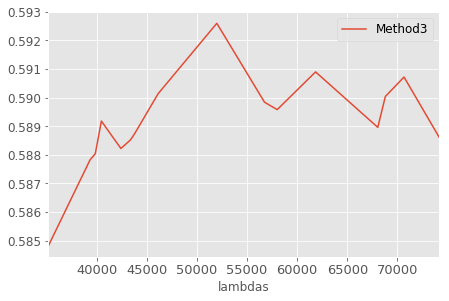

In [23]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')